In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import contextily as cx 
import plotly.express as px 
import plotly.io as pio
import plotly.graph_objects as go
import cufflinks as cf
cf.go_offline()
import rasterio 
from rasterio import plot as rioplot 
from rasterio.mask import mask  
from linearmodels import PooledOLS 
from linearmodels import PanelOLS 
from linearmodels import BetweenOLS 
from linearmodels.panel.results import compare 
import inequality 
from shapely.geometry import mapping
import os
import glob
from scipy.signal import medfilt
from scipy.stats import scoreatpercentile
from rasterio.transform import from_origin
from shapely.ops import transform
from functools import partial
import pyproj
from geopy.distance import geodesic

# Set the float format to prevent scientific notation
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)

In [296]:
# Specify the path to your zip file
# zip_file_path = "/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/INDIAN-SHAPEFILES-master/sub_dist.zip"
# zip_file_path = "/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/INDIAN-SHAPEFILES-master/Dist_2022.zip"

# Read the shapefile from the zip file using GeoPandas
gdf = gpd.read_file('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/maps-master/geojson/sub_dist.geojson')

# Now you can work with the GeoDataFrame (gdf) containing the shapefile data
gdf_NTL = gdf.copy()
gdf

,NAME,DISTRICT,STATE_UT,geometry
0,DATA NOT AVAILABLE,DATA NOT AVAILABLE,Jammu & Kashmir,"MULTIPOLYGON (((74.77117 37.01042, 74.77968 36..."
1,NaN,Kachchh,Gujarat,"MULTIPOLYGON (((70.12473 22.97347, 70.12521 22..."
2,KACHCHH (PART),Kachchh,Gujarat,"MULTIPOLYGON (((71.30731 24.56554, 71.30731 24..."
3,Kupwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((74.57425 34.59931, 74.56734 34..."
4,Handwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((74.13457 34.44413, 74.13615 34..."
...,...,...,...,...
6070,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.72334 12.73736, 92.72345 12..."
6071,Rangat,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.75932 12.16706, 92.75909 12..."
6072,Ferrargunj,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.60467 11.53490, 92.60471 11..."
6073,Port Blair,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.61728 10.92835, 92.61446 10..."


## Cleaning TIF File

In [4]:
## Replacing Negative Values

def replace_negative(radiance_datacube, replacement=0):
    # Create a mask for negative values
    negative_mask = radiance_datacube < 0
    
    # Replace negative values with replacement
    radiance_datacube[negative_mask] = replacement
    
    return radiance_datacube

In [5]:

# Directory containing the TIF files
tif_folder = "/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/VIIRS_Monthly_Tiled/2020/"

# Loop through all files in the directory
for file_name in os.listdir(tif_folder):
    # Check if the file is a TIF file
    if file_name.endswith(".tif"):
        # Construct the full path to the TIF file
        raster_path = os.path.join(tif_folder, file_name)
        
        # Open the raster file
        with rasterio.open(raster_path) as rasterFile:
            # Read the affine transformation matrix
            transform = rasterFile.transform
            # Get the pixel dimensions
            x_size = rasterFile.width
            y_size = rasterFile.height
            
            # Get the top-left corner coordinates
            top_left_x, top_left_y = transform * (0, 0)
            # Get the bottom-right corner coordinates
            bottom_right_x, bottom_right_y = transform * (x_size, y_size)
            # Calculate the pixel size in the x and y directions
            pixel_width = (bottom_right_x - top_left_x) / x_size
            pixel_height = (bottom_right_y - top_left_y) / y_size
            
            # Generate arrays of latitude and longitude for each pixel
            lons = top_left_x + pixel_width / 2 + pixel_width * np.arange(x_size)  # Longitudes
            lats = top_left_y + pixel_height / 2 + pixel_height * np.arange(y_size)[::-1]  # Latitudes (reversed)
            
            # Read the radiance data for the current month
            radiance_data = rasterFile.read(1)
            # Replace negative values with NaN
            radiance_data = replace_negative(radiance_data)
            
            # Assuming lons is your original 1D array
            lons_reshaped = np.reshape(lons, (x_size, 1))
            # Repeat lons_reshaped 18000 times along axis 1 (columns)
            lons_repeated = np.tile(lons_reshaped, (1, y_size))
            print(lons_reshaped.shape) 
            print(lons_repeated.shape)
            
            # Assuming lats is your original 1D array
            lats_reshaped = np.reshape(lats, (1, y_size))
            # Repeat lats_reshaped 28800 times along axis 0 (rows)
            lats_repeated = np.tile(lats_reshaped, (x_size, 1))
            
            # Calculate the extent of the raster
            xmin, ymin, xmax, ymax = [lons_repeated.min(), lats_repeated.min(), lons_repeated.max(), lats_repeated.max()]
            nrows, ncols = radiance_data.shape
            xres = (xmax - xmin) / float(ncols)
            yres = (ymax - ymin) / float(nrows)
            
            # Define the coordinate reference system (CRS) - WGS84
            crs = 'EPSG:4326'
            
            # Create the transformation matrix
            transform = from_origin(xmin, ymax, xres, yres)
            
            # Define the output file path
            output_file = f'/Users/sid/Desktop/output_raster_{file_name}'
            
            # Create the raster file and write the array data
            with rasterio.open(
                output_file,
                'w',
                driver='GTiff',
                height=nrows,
                width=ncols,
                count=1,
                dtype=radiance_data.dtype,
                # crs=crs,
                transform=transform,
            ) as dst:
                dst.write(radiance_data, 1)


(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)
(28800, 1)
(28800, 18000)


In [29]:
## Recoding 0 to missing data

def na_recode(radiance_datacube, ncfobs_datacube, replacement=np.nan):
    # Replace missing values in radiance_datacube with np.nan
    radiance_datacube = np.where(radiance_datacube == None, np.nan, radiance_datacube)
    
    # Loop through each element in the datacube
    for i in range(radiance_datacube.shape[0]):
        for j in range(radiance_datacube.shape[1]):
            # for k in range(radiance_datacube.shape[2]):
                # Check if corresponding value in ncfobs_datacube is 0
            if ncfobs_datacube[i, j] == 0:
                    # If so, replace value in radiance_datacube with replacement
                radiance_datacube[i, j] = replacement
    
    return radiance_datacube

In [ ]:
## Dealing with outliers

def outlier_variance(radiance_datacube, mask=None, cutoff=0.999):
    if mask is None:
        mask = np.ones_like(radiance_datacube, dtype=np.int8)

    def std_mask(std, threshold):
        return 1 if std < threshold else np.nan

    stds = np.zeros_like(radiance_datacube)
    for i in range(radiance_datacube.shape[0]):
        for j in range(radiance_datacube.shape[1]):
            if np.isnan(mask[i, j]):
                continue
            if np.count_nonzero(np.isnan(radiance_datacube[i, j])) / radiance_datacube.shape[2] > 0.90:
                continue
            valid_data = radiance_datacube[i, j, ~np.isnan(radiance_datacube[i, j])]
            stds[i, j] = np.std(medfilt(valid_data, kernel_size=3))

    threshold = scoreatpercentile(stds.ravel() * mask.ravel(), cutoff * 100)
    outlierMask = np.vectorize(std_mask)(stds, threshold)
    outlierMask *= mask
    return outlierMask

# def outlier_hampel(radiance_pixel_ts, window_size=5, n_sigmas=3):
#     new_series = radiance_pixel_ts.copy()
#     missings = np.where(np.isnan(new_series))[0]

#     for i in range(window_size, len(new_series) - window_size):
#         x0 = np.nanmedian(new_series[i - window_size:i + window_size + 1])
#         S0 = 1.4826 * np.nanmedian(np.abs(new_series[i - window_size:i + window_size + 1] - x0))
#         if np.abs(new_series[i] - x0) > n_sigmas * S0:
#             new_series[i] = np.nan

#     for i in missings:
#         new_series[i] = np.nan

#     return new_series

In [ ]:
def na_recode(radiance_datacube, ncfobs_datacube, replacement=np.nan):
    # Replace missing values in radiance_datacube with np.nan
    radiance_datacube = np.where(np.isnan(radiance_datacube), replacement, radiance_datacube)
    
    # Check the dimensions of the radiance_datacube array
    if radiance_datacube.ndim == 2:  # If it's two-dimensional
        # Check if corresponding value in ncfobs_datacube is 0
        if ncfobs_datacube == 0:
            # If so, replace value in radiance_datacube with replacement
            radiance_datacube = replacement
    elif radiance_datacube.ndim == 3:  # If it's three-dimensional
        # Loop through each element in the datacube
        for i in range(radiance_datacube.shape[0]):
            for j in range(radiance_datacube.shape[1]):
                for k in range(radiance_datacube.shape[2]):
                    # Check if corresponding value in ncfobs_datacube is 0
                    if ncfobs_datacube[i, j, k] == 0:
                        # If so, replace value in radiance_datacube with replacement
                        radiance_datacube[i, j, k] = replacement
    else:
        raise ValueError("Unsupported number of dimensions in radiance_datacube")

    return radiance_datacube


## Reading TIF Data

In [299]:
# Loop through each month
for month in range(1, 13):
    # Construct the path to the raster file for the current month
    raster_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/VIIRS_Monthly_Tiled/2020/clean_files/output_raster_2020{month:02d}.tif"
    cf_cvg_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/VIIRS_Monthly_Tiled/cf_cvg/2020_cvg/2020{month:02d}.tif"
    
    # Open the raster file
    with rasterio.open(raster_path) as rasterFile, rasterio.open(cf_cvg_path) as cf_cvg_file:
        # Read the data from cloud-free coverage file
        cf_cvg_data = cf_cvg_file.read(1)

        # Define a function to create mask for the current month
        def clean_mask(geom, dataset=rasterFile, mask_kw=None):
            mask_kw = mask_kw or {}
            mask_kw.setdefault("crop", True)
            mask_kw.setdefault("all_touched", True)
            masked, mask_transform = mask(dataset=dataset, shapes=[geom], **mask_kw)
            # print(f"Shape of masked array: {masked.shape}")  # Debugging
            return masked
        
        # Apply mask to each geometry and calculate sum of luminosity for the current month
        statewise_agg_ntl = gdf.geometry.apply(clean_mask).apply(np.ma.sum)
        # statewise_agg_ntl = gdf.geometry.apply(lambda geom: clean_mask(geom, dataset=rasterFile, mask_kw={"crop": True, "all_touched": True}))
        # statewise_agg_ntl = np.array(statewise_agg_ntl) 

        print(f"Month: {month}, radiance_datacube shape: {statewise_agg_ntl.shape}")  # Debugging
        

        # Call na_recode to replace negative values with NaN
        # statewise_agg_ntl = na_recode(statewise_agg_ntl, cf_cvg_data)
        
        # Replace negative values with NaN
        # statewise_agg_ntl = replace_negative(statewise_agg_ntl)
        
        # Add a column to the DataFrame for the current month
        gdf_NTL[f"2020{month:02d}"] = statewise_agg_ntl

gdf_NTL


Month: 1, radiance_datacube shape: (6075,)
Month: 2, radiance_datacube shape: (6075,)
Month: 3, radiance_datacube shape: (6075,)
Month: 4, radiance_datacube shape: (6075,)
Month: 5, radiance_datacube shape: (6075,)
Month: 6, radiance_datacube shape: (6075,)
Month: 7, radiance_datacube shape: (6075,)
Month: 8, radiance_datacube shape: (6075,)
Month: 9, radiance_datacube shape: (6075,)
Month: 10, radiance_datacube shape: (6075,)
Month: 11, radiance_datacube shape: (6075,)
Month: 12, radiance_datacube shape: (6075,)


,NAME,DISTRICT,STATE_UT,geometry,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
0,DATA NOT AVAILABLE,DATA NOT AVAILABLE,Jammu & Kashmir,"MULTIPOLYGON (((74.77117 37.01042, 74.77968 36...",124161.25000,193731.89062,162918.87500,179731.76562,177163.29688,32352.64648,159449.04688,155211.78125,167454.92188,198722.68750,241790.35938,212657.35938
1,NaN,Kachchh,Gujarat,"MULTIPOLYGON (((70.12473 22.97347, 70.12521 22...",9516.66992,8817.54004,8628.46973,7799.21973,7846.53027,9079.72070,7779.26025,3944.61987,7298.09961,8444.10938,8615.79980,9276.39062
2,KACHCHH (PART),Kachchh,Gujarat,"MULTIPOLYGON (((71.30731 24.56554, 71.30731 24...",10046.19922,32603.10938,40589.22266,48361.94141,41784.88281,41336.48438,33409.13281,28447.97656,36636.38281,35395.48828,38295.25000,30377.13867
3,Kupwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((74.57425 34.59931, 74.56734 34...",4135.38965,4403.96973,3609.89990,4184.52002,4710.69971,0.00000,4582.54004,4772.08008,5007.45020,4967.87988,5139.57031,4571.77051
4,Handwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((74.13457 34.44413, 74.13615 34...",1797.08997,2186.54980,1780.48999,2249.07007,2372.64990,483.92999,2343.02026,2442.75024,2422.88013,2442.51001,2695.14014,2587.10986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.72334 12.73736, 92.72345 12...",113.83000,893.63007,1225.99988,1488.10999,1128.68994,1066.62012,733.29004,1127.55005,23.93000,714.31006,994.87000,663.83997
6071,Rangat,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.75932 12.16706, 92.75909 12...",206.89000,1720.89014,2356.46997,2886.10986,2334.14014,2094.84009,781.61993,2163.97998,320.61002,1716.02002,1921.32007,1252.73999
6072,Ferrargunj,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.60467 11.53490, 92.60471 11...",554.67993,1968.39014,2574.48975,2915.14014,2334.39990,1561.98999,1483.42993,2065.37012,291.03998,1879.39001,1935.44995,1362.37000
6073,Port Blair,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.61728 10.92835, 92.61446 10...",2431.72998,3162.17041,3495.06982,3192.52026,2579.44995,2394.90991,1581.67004,2632.45996,224.25002,2188.38989,2634.07007,2466.33984


In [300]:
gdf_2 = gdf_NTL.copy()
# Reproject to a suitable projected CRS for accurate area calculations
gdf_2 = gdf_2.to_crs('EPSG:3857')  # Example: Albers Equal Area Conic for India (EPSG:102033)

# Calculate the area in square kilometers
gdf_2['area_sq_km'] = gdf_2.geometry.area / 1e6

gdf_2

,NAME,DISTRICT,STATE_UT,geometry,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km
0,DATA NOT AVAILABLE,DATA NOT AVAILABLE,Jammu & Kashmir,"MULTIPOLYGON (((8323488.745 4440559.545, 83244...",124161.25000,193731.89062,162918.87500,179731.76562,177163.29688,32352.64648,159449.04688,155211.78125,167454.92188,198722.68750,241790.35938,212657.35938,122025.77648
1,NaN,Kachchh,Gujarat,"MULTIPOLYGON (((7806249.566 2628810.681, 78063...",9516.66992,8817.54004,8628.46973,7799.21973,7846.53027,9079.72070,7779.26025,3944.61987,7298.09961,8444.10938,8615.79980,9276.39062,319.89311
2,KACHCHH (PART),Kachchh,Gujarat,"MULTIPOLYGON (((7937893.663 2822474.654, 79378...",10046.19922,32603.10938,40589.22266,48361.94141,41784.88281,41336.48438,33409.13281,28447.97656,36636.38281,35395.48828,38295.25000,30377.13867,25375.38505
3,Kupwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((8301567.455 4109561.667, 83007...",4135.38965,4403.96973,3609.89990,4184.52002,4710.69971,0.00000,4582.54004,4772.08008,5007.45020,4967.87988,5139.57031,4571.77051,2334.34825
4,Handwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((8252622.278 4088594.875, 82527...",1797.08997,2186.54980,1780.48999,2249.07007,2372.64990,483.92999,2343.02026,2442.75024,2422.88013,2442.51001,2695.14014,2587.10986,1298.88855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((10321915.316 1429742.030, 1032...",113.83000,893.63007,1225.99988,1488.10999,1128.68994,1066.62012,733.29004,1127.55005,23.93000,714.31006,994.87000,663.83997,699.23869
6071,Rangat,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((10325920.616 1364726.821, 1032...",206.89000,1720.89014,2356.46997,2886.10986,2334.14014,2094.84009,781.61993,2163.97998,320.61002,1716.02002,1921.32007,1252.73999,1382.74511
6072,Ferrargunj,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((10308704.449 1292822.035, 1030...",554.67993,1968.39014,2574.48975,2915.14014,2334.39990,1561.98999,1483.42993,2065.37012,291.03998,1879.39001,1935.44995,1362.37000,1272.41244
6073,Port Blair,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((10310108.343 1223982.511, 1030...",2431.72998,3162.17041,3495.06982,3192.52026,2579.44995,2394.90991,1581.67004,2632.45996,224.25002,2188.38989,2634.07007,2466.33984,545.97142


In [301]:
aggregated_df = gdf_2.groupby(['NAME', 'DISTRICT', 'STATE_UT']).sum().reset_index()
aggregated_df

/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_11957/2170233344.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,NAME,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km
0,A.Konduru,Krishna,Andhra Pradesh,445.75000,726.95001,812.22003,833.39996,754.30005,723.50000,514.33997,199.76001,707.68994,652.72998,709.20996,702.82001,224.79743
1,Aali,Kendrapara,Odisha,565.97003,956.70001,967.28003,1020.59998,908.25000,771.03003,845.08997,614.33997,682.01001,815.63000,1155.41992,881.48004,264.38790
2,Aalo,West Siang,Arunachal Pradesh,161.90999,818.09998,735.44000,711.08008,841.65002,878.07001,337.42999,745.09998,1015.92004,864.35999,944.18994,777.91998,514.40899
3,Abdasa,Kachchh,Gujarat,3269.30005,6433.43994,7752.19043,8180.68018,7557.76953,7672.23047,5627.08008,5571.67969,6264.88037,7069.81934,6938.97949,6108.97021,3314.61682
4,Abhanpur,Raipur,Chhattisgarh,3799.38989,5293.43994,4465.41992,4217.58984,4055.20996,715.70996,141.87999,2148.14990,2334.33984,4224.10986,5646.41016,4920.50977,710.75582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,Ziradei,Siwan,Bihar,1082.58997,1366.04993,1221.77002,1294.58997,1033.91003,582.76001,391.38000,613.21997,721.78998,753.18005,1653.70996,1162.40002,160.53575
5986,Ziro (Sadar),Lower Subansiri,Arunachal Pradesh,236.67999,606.45996,626.83997,630.85999,492.57999,609.98999,91.89000,420.88000,566.40002,591.79999,709.81006,668.28998,316.89622
5987,Zuketsa,Phek,Nagaland,25.61000,51.61000,53.23000,57.31000,52.51000,43.42000,24.26000,42.86000,56.55000,51.35000,53.58000,76.39000,23.10691
5988,Zunheboto Sadar,Zunheboto,Nagaland,484.75995,685.87000,635.50000,688.14001,573.60999,475.01999,186.39999,469.50000,531.33997,533.96997,696.75000,1114.07007,192.54341


In [303]:
pop_data = pd.read_csv('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/GPW/IN_Subdist.csv')

In [304]:
selected_columns = aggregated_df[['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']]

# Calculating quartiles for each row
quartiles = selected_columns.quantile([0.20, 0.75], axis=1).T
quartiles.columns = ['Q1', 'Q3']  # Rename columns to Q1 and Q3
quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']
quartiles['U_bound'] = quartiles['Q3'] + 1.5*quartiles['IQR']
quartiles['L_bound'] = quartiles['Q1'].clip(lower=0)  # Clip to ensure it's not negative 
# quartiles['L_bound'] = quartiles['L_bound']

# Adding Q1 and Q3 columns to the original DataFrame
df = pd.concat([aggregated_df, quartiles], axis=1)
# Computing IQR for each row
# iqr = quartiles.loc[0.75] - quartiles.loc[0.25]

# Printing or storing the IQR values
# print(iqr)
df

,NAME,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km,Q1,Q3,IQR,U_bound,L_bound
0,A.Konduru,Krishna,Andhra Pradesh,445.75000,726.95001,812.22003,833.39996,754.30005,723.50000,514.33997,199.76001,707.68994,652.72998,709.20996,702.82001,224.79743,542.01797,733.78752,191.76955,1021.44185,542.01797
1,Aali,Kendrapara,Odisha,565.97003,956.70001,967.28003,1020.59998,908.25000,771.03003,845.08997,614.33997,682.01001,815.63000,1155.41992,881.48004,264.38790,699.81401,959.34502,259.53100,1348.64152,699.81401
2,Aalo,West Siang,Arunachal Pradesh,161.90999,818.09998,735.44000,711.08008,841.65002,878.07001,337.42999,745.09998,1015.92004,864.35999,944.18994,777.91998,514.40899,715.95206,867.78749,151.83543,1095.54063,715.95206
3,Abdasa,Kachchh,Gujarat,3269.30005,6433.43994,7752.19043,8180.68018,7557.76953,7672.23047,5627.08008,5571.67969,6264.88037,7069.81934,6938.97949,6108.97021,3314.61682,5723.45811,7586.38477,1862.92666,10380.77476,5723.45811
4,Abhanpur,Raipur,Chhattisgarh,3799.38989,5293.43994,4465.41992,4217.58984,4055.20996,715.70996,141.87999,2148.14990,2334.33984,4224.10986,5646.41016,4920.50977,710.75582,2185.38789,4579.19238,2393.80449,8169.89912,2185.38789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,Ziradei,Siwan,Bihar,1082.58997,1366.04993,1221.77002,1294.58997,1033.91003,582.76001,391.38000,613.21997,721.78998,753.18005,1653.70996,1162.40002,160.53575,634.93397,1239.97501,605.04103,2147.53656,634.93397
5986,Ziro (Sadar),Lower Subansiri,Arunachal Pradesh,236.67999,606.45996,626.83997,630.85999,492.57999,609.98999,91.89000,420.88000,566.40002,591.79999,709.81006,668.28998,316.89622,435.22000,627.84497,192.62497,916.78242,435.22000
5987,Zuketsa,Phek,Nagaland,25.61000,51.61000,53.23000,57.31000,52.51000,43.42000,24.26000,42.86000,56.55000,51.35000,53.58000,76.39000,23.10691,42.97200,54.32250,11.35050,71.34825,42.97200
5988,Zunheboto Sadar,Zunheboto,Nagaland,484.75995,685.87000,635.50000,688.14001,573.60999,475.01999,186.39999,469.50000,531.33997,533.96997,696.75000,1114.07007,192.54341,476.96798,686.43750,209.46952,1000.64178,476.96798


In [305]:
avg_columns = ['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']
# Create a mask to filter out values below L_Bound
mask = df[avg_columns].values > df['L_bound'].values[:, None]

# Replace values below L_Bound with NaN
masked_data = df[avg_columns].where(mask)

# Calculate row-wise mean
row_means = masked_data.mean(axis=1)

# Add row-wise mean to DataFrame
df['avg_ntl'] = row_means

# Printing the updated DataFrame
df

# df[avg_columns].mean(axis=1)

,NAME,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km,Q1,Q3,IQR,U_bound,L_bound,avg_ntl
0,A.Konduru,Krishna,Andhra Pradesh,445.75000,726.95001,812.22003,833.39996,754.30005,723.50000,514.33997,199.76001,707.68994,652.72998,709.20996,702.82001,224.79743,542.01797,733.78752,191.76955,1021.44185,542.01797,735.86890
1,Aali,Kendrapara,Odisha,565.97003,956.70001,967.28003,1020.59998,908.25000,771.03003,845.08997,614.33997,682.01001,815.63000,1155.41992,881.48004,264.38790,699.81401,959.34502,259.53100,1348.64152,699.81401,924.60895
2,Aalo,West Siang,Arunachal Pradesh,161.90999,818.09998,735.44000,711.08008,841.65002,878.07001,337.42999,745.09998,1015.92004,864.35999,944.18994,777.91998,514.40899,715.95206,867.78749,151.83543,1095.54063,715.95206,846.74994
3,Abdasa,Kachchh,Gujarat,3269.30005,6433.43994,7752.19043,8180.68018,7557.76953,7672.23047,5627.08008,5571.67969,6264.88037,7069.81934,6938.97949,6108.97021,3314.61682,5723.45811,7586.38477,1862.92666,10380.77476,5723.45811,7108.77344
4,Abhanpur,Raipur,Chhattisgarh,3799.38989,5293.43994,4465.41992,4217.58984,4055.20996,715.70996,141.87999,2148.14990,2334.33984,4224.10986,5646.41016,4920.50977,710.75582,2185.38789,4579.19238,2393.80449,8169.89912,2185.38789,4328.49121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,Ziradei,Siwan,Bihar,1082.58997,1366.04993,1221.77002,1294.58997,1033.91003,582.76001,391.38000,613.21997,721.78998,753.18005,1653.70996,1162.40002,160.53575,634.93397,1239.97501,605.04103,2147.53656,634.93397,1143.33228
5986,Ziro (Sadar),Lower Subansiri,Arunachal Pradesh,236.67999,606.45996,626.83997,630.85999,492.57999,609.98999,91.89000,420.88000,566.40002,591.79999,709.81006,668.28998,316.89622,435.22000,627.84497,192.62497,916.78242,435.22000,611.44775
5987,Zuketsa,Phek,Nagaland,25.61000,51.61000,53.23000,57.31000,52.51000,43.42000,24.26000,42.86000,56.55000,51.35000,53.58000,76.39000,23.10691,42.97200,54.32250,11.35050,71.34825,42.97200,55.10556
5988,Zunheboto Sadar,Zunheboto,Nagaland,484.75995,685.87000,635.50000,688.14001,573.60999,475.01999,186.39999,469.50000,531.33997,533.96997,696.75000,1114.07007,192.54341,476.96798,686.43750,209.46952,1000.64178,476.96798,660.44556


In [311]:
pc = pd.merge(df,pop_data,on=['NAME','DISTRICT','STATE_UT'],how='inner')
pc['subdist_ntl_pa']  = pc['avg_ntl']/pc['area_sq_km']
pc['subdist_ntl_pc']  = pc['avg_ntl']/pc['pop']

pc = pc.rename(columns={'pop': 'Subdistrict_pop'})
pc

,NAME,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km,Q1,Q3,IQR,U_bound,L_bound,avg_ntl,Subdistrict_pop,subdist_ntl_pa,subdist_ntl_pc
0,A.Konduru,Krishna,Andhra Pradesh,445.75000,726.95001,812.22003,833.39996,754.30005,723.50000,514.33997,199.76001,707.68994,652.72998,709.20996,702.82001,224.79743,542.01797,733.78752,191.76955,1021.44185,542.01797,735.86890,52165.50781,3.27348,0.01411
1,Aali,Kendrapara,Odisha,565.97003,956.70001,967.28003,1020.59998,908.25000,771.03003,845.08997,614.33997,682.01001,815.63000,1155.41992,881.48004,264.38790,699.81401,959.34502,259.53100,1348.64152,699.81401,924.60895,190835.34380,3.49717,0.00485
2,Aalo,West Siang,Arunachal Pradesh,161.90999,818.09998,735.44000,711.08008,841.65002,878.07001,337.42999,745.09998,1015.92004,864.35999,944.18994,777.91998,514.40899,715.95206,867.78749,151.83543,1095.54063,715.95206,846.74994,30835.29297,1.64606,0.02746
3,Abdasa,Kachchh,Gujarat,3269.30005,6433.43994,7752.19043,8180.68018,7557.76953,7672.23047,5627.08008,5571.67969,6264.88037,7069.81934,6938.97949,6108.97021,3314.61682,5723.45811,7586.38477,1862.92666,10380.77476,5723.45811,7108.77344,168441.70310,2.14467,0.04220
4,Abhanpur,Raipur,Chhattisgarh,3799.38989,5293.43994,4465.41992,4217.58984,4055.20996,715.70996,141.87999,2148.14990,2334.33984,4224.10986,5646.41016,4920.50977,710.75582,2185.38789,4579.19238,2393.80449,8169.89912,2185.38789,4328.49121,579391.56250,6.08998,0.00747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6068,Ziradei,Siwan,Bihar,1082.58997,1366.04993,1221.77002,1294.58997,1033.91003,582.76001,391.38000,613.21997,721.78998,753.18005,1653.70996,1162.40002,160.53575,634.93397,1239.97501,605.04103,2147.53656,634.93397,1143.33228,221637.78130,7.12198,0.00516
6069,Ziro (Sadar),Lower Subansiri,Arunachal Pradesh,236.67999,606.45996,626.83997,630.85999,492.57999,609.98999,91.89000,420.88000,566.40002,591.79999,709.81006,668.28998,316.89622,435.22000,627.84497,192.62497,916.78242,435.22000,611.44775,31808.65039,1.92949,0.01922
6070,Zuketsa,Phek,Nagaland,25.61000,51.61000,53.23000,57.31000,52.51000,43.42000,24.26000,42.86000,56.55000,51.35000,53.58000,76.39000,23.10691,42.97200,54.32250,11.35050,71.34825,42.97200,55.10556,4462.01514,2.38481,0.01235
6071,Zunheboto Sadar,Zunheboto,Nagaland,484.75995,685.87000,635.50000,688.14001,573.60999,475.01999,186.39999,469.50000,531.33997,533.96997,696.75000,1114.07007,192.54341,476.96798,686.43750,209.46952,1000.64178,476.96798,660.44556,30010.50391,3.43011,0.02201


## Merging with Population

In [312]:
gpw = pd.read_csv('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/GPW/IN_Subdist.csv')
aggregated_df2 = gpw.groupby(['NAME', 'DISTRICT', 'STATE_UT']).sum().reset_index()
aggregated_df2

,NAME,DISTRICT,STATE_UT,pop
0,A.Konduru,Krishna,Andhra Pradesh,52165.50781
1,Aali,Kendrapara,Odisha,190835.34380
2,Aalo,West Siang,Arunachal Pradesh,30835.29297
3,Abdasa,Kachchh,Gujarat,168441.70310
4,Abhanpur,Raipur,Chhattisgarh,579391.56250
...,...,...,...,...
5984,Ziradei,Siwan,Bihar,221637.78130
5985,Ziro (Sadar),Lower Subansiri,Arunachal Pradesh,31808.65039
5986,Zuketsa,Phek,Nagaland,4462.01514
5987,Zunheboto Sadar,Zunheboto,Nagaland,30010.50391


In [313]:
full = pd.merge(pc,aggregated_df2,on=['NAME','DISTRICT','STATE_UT'],how='left')
full['subdist_ntl_pa']  = full['avg_ntl']/full['area_sq_km']
full

,NAME,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km,Q1,Q3,IQR,U_bound,L_bound,avg_ntl,Subdistrict_pop,subdist_ntl_pa,subdist_ntl_pc,pop
0,A.Konduru,Krishna,Andhra Pradesh,445.75000,726.95001,812.22003,833.39996,754.30005,723.50000,514.33997,199.76001,707.68994,652.72998,709.20996,702.82001,224.79743,542.01797,733.78752,191.76955,1021.44185,542.01797,735.86890,52165.50781,3.27348,0.01411,52165.50781
1,Aali,Kendrapara,Odisha,565.97003,956.70001,967.28003,1020.59998,908.25000,771.03003,845.08997,614.33997,682.01001,815.63000,1155.41992,881.48004,264.38790,699.81401,959.34502,259.53100,1348.64152,699.81401,924.60895,190835.34380,3.49717,0.00485,190835.34380
2,Aalo,West Siang,Arunachal Pradesh,161.90999,818.09998,735.44000,711.08008,841.65002,878.07001,337.42999,745.09998,1015.92004,864.35999,944.18994,777.91998,514.40899,715.95206,867.78749,151.83543,1095.54063,715.95206,846.74994,30835.29297,1.64606,0.02746,30835.29297
3,Abdasa,Kachchh,Gujarat,3269.30005,6433.43994,7752.19043,8180.68018,7557.76953,7672.23047,5627.08008,5571.67969,6264.88037,7069.81934,6938.97949,6108.97021,3314.61682,5723.45811,7586.38477,1862.92666,10380.77476,5723.45811,7108.77344,168441.70310,2.14467,0.04220,168441.70310
4,Abhanpur,Raipur,Chhattisgarh,3799.38989,5293.43994,4465.41992,4217.58984,4055.20996,715.70996,141.87999,2148.14990,2334.33984,4224.10986,5646.41016,4920.50977,710.75582,2185.38789,4579.19238,2393.80449,8169.89912,2185.38789,4328.49121,579391.56250,6.08998,0.00747,579391.56250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6068,Ziradei,Siwan,Bihar,1082.58997,1366.04993,1221.77002,1294.58997,1033.91003,582.76001,391.38000,613.21997,721.78998,753.18005,1653.70996,1162.40002,160.53575,634.93397,1239.97501,605.04103,2147.53656,634.93397,1143.33228,221637.78130,7.12198,0.00516,221637.78130
6069,Ziro (Sadar),Lower Subansiri,Arunachal Pradesh,236.67999,606.45996,626.83997,630.85999,492.57999,609.98999,91.89000,420.88000,566.40002,591.79999,709.81006,668.28998,316.89622,435.22000,627.84497,192.62497,916.78242,435.22000,611.44775,31808.65039,1.92949,0.01922,31808.65039
6070,Zuketsa,Phek,Nagaland,25.61000,51.61000,53.23000,57.31000,52.51000,43.42000,24.26000,42.86000,56.55000,51.35000,53.58000,76.39000,23.10691,42.97200,54.32250,11.35050,71.34825,42.97200,55.10556,4462.01514,2.38481,0.01235,4462.01514
6071,Zunheboto Sadar,Zunheboto,Nagaland,484.75995,685.87000,635.50000,688.14001,573.60999,475.01999,186.39999,469.50000,531.33997,533.96997,696.75000,1114.07007,192.54341,476.96798,686.43750,209.46952,1000.64178,476.96798,660.44556,30010.50391,3.43011,0.02201,30010.50391


In [317]:
aggregated_full = full.groupby(['DISTRICT', 'STATE_UT']).sum().reset_index()
aggregated_full['dist_ntl_pa']  = aggregated_full['avg_ntl']/aggregated_full['area_sq_km']
aggregated_full['dist_ntl_pc']  = aggregated_full['avg_ntl']/aggregated_full['Subdistrict_pop']


aggregated_full = aggregated_full.drop(['202001', '202002', '202003', '202004',
       '202005', '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', 'area_sq_km', 'Q1', 'Q3', 'IQR', 'U_bound', 'L_bound',
       'avg_ntl', 'pop','subdist_ntl_pa','subdist_ntl_pc','Subdistrict_pop'], axis=1)
aggregated_full

/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_11957/3573404393.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,DISTRICT,STATE_UT,dist_ntl_pa,dist_ntl_pc
0,Adilabad,Andhra Pradesh,3.28493,0.02035
1,Agra,Uttar Pradesh,10.24325,0.00979
2,Ahmadabad,Gujarat,10.96803,0.01186
3,Ahmadnagar,Maharashtra,5.14603,0.01933
4,Aizawl,Mizoram,1.72361,0.01394
...,...,...,...,...
635,Yadgir,Karnataka,3.27652,0.01401
636,Yamunanagar,Haryana,7.19744,0.01262
637,Yanam,Puducherry,28.53387,0.03640
638,Yavatmal,Maharashtra,3.36483,0.01667


In [320]:
full2 = pd.merge(full,aggregated_full,on=['DISTRICT','STATE_UT'],how='left')z


full_sorted = full2.sort_values(by=['STATE_UT','DISTRICT', 'subdist_ntl_pc'])
full_sorted['Index'] = full_sorted.groupby(['STATE_UT','DISTRICT']).cumcount() + 1
# Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
full_sorted['Max_Len'] = full_sorted.groupby(['STATE_UT','DISTRICT'])['Index'].transform('max')
full_sorted = full_sorted.drop(['202001', '202002', '202003', '202004',
       '202005', '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', 'area_sq_km', 'Q1', 'Q3', 'IQR', 'U_bound', 'L_bound'], axis=1)

full_sorted

,NAME,DISTRICT,STATE_UT,avg_ntl,Subdistrict_pop,subdist_ntl_pa,subdist_ntl_pc,pop,dist_ntl_pa,dist_ntl_pc,Index,Max_Len
1080,Car Nicobar,Nicobars,Andaman & Nicobar Islands,289.48999,14409.14258,2.19783,0.02009,14409.14258,1.46443,0.08501,1,3
3897,Nancowry,Nicobars,Andaman & Nicobar Islands,711.37885,7917.44189,1.52419,0.08985,7917.44189,1.46443,0.08501,2,3
1991,Great Nicobar,Nicobars,Andaman & Nicobar Islands,1497.50220,7060.90820,1.35203,0.21208,7060.90820,1.46443,0.08501,3,3
3599,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,1041.45227,24818.98828,1.48941,0.04196,24818.98828,1.49060,0.05324,1,3
1606,Diglipur,North & Middle Andaman,Andaman & Nicobar Islands,2232.75537,41954.91797,1.49889,0.05322,41954.91797,1.49060,0.05324,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1329,Chopra,Uttar Dinajpur,West Bengal,2446.51245,280278.18750,5.11148,0.00873,280278.18750,7.09601,0.00884,9,13
304,Area not under any Sub-district,Uttar Dinajpur,West Bengal,2865.29883,22424.93750,42.97137,0.12777,62831.38671,7.09601,0.00884,10,13
305,Area not under any Sub-district,Uttar Dinajpur,West Bengal,2865.29883,17688.79492,42.97137,0.16198,62831.38671,7.09601,0.00884,11,13
306,Area not under any Sub-district,Uttar Dinajpur,West Bengal,2865.29883,13706.24902,42.97137,0.20905,62831.38671,7.09601,0.00884,12,13


In [341]:
def calculate_alesina(group):
    sum_y = group['subdist_ntl_pc'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['subdist_ntl_pc'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

# Calculate WCV for each state using groupby and apply
all = full_sorted.groupby([
    'DISTRICT','STATE_UT',
                        #   'dist_ntl','dist_population',
                          'dist_ntl_pc'
                          ]).apply(calculate_alesina).reset_index()

# Reset the index and rename the result column
all.columns = ['DISTRICT','STATE_UT','dist_ntl_pc',
            #    'dist_population','dist_ntl_pc',
               'sum_y','numerator', 'num','alesina']


all

/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_11957/1101204532.py:6: RuntimeWarning:

invalid value encountered in scalar divide



,DISTRICT,STATE_UT,dist_ntl_pc,sum_y,numerator,num,alesina
0,Adilabad,Andhra Pradesh,0.02035,1.14853,24.88109,52.00000,0.18603
1,Agra,Uttar Pradesh,0.00979,0.06028,0.18612,6.00000,0.13741
2,Ahmadabad,Gujarat,0.01186,0.25149,1.18612,11.00000,0.23340
3,Ahmadnagar,Maharashtra,0.01933,0.27412,1.81475,14.00000,0.12569
4,Aizawl,Mizoram,0.01394,0.15209,0.33209,5.00000,0.32660
...,...,...,...,...,...,...,...
635,Yadgir,Karnataka,0.01401,0.04217,0.08185,3.00000,0.03943
636,Yamunanagar,Haryana,0.01262,0.04032,0.07742,3.00000,0.05316
637,Yanam,Puducherry,0.03640,0.03640,0.03640,1.00000,0.00000
638,Yavatmal,Maharashtra,0.01667,0.28411,2.13276,16.00000,0.12415


In [342]:
full3 = pd.merge(full_sorted,all,on=['DISTRICT','STATE_UT'],how='left')
full3

,NAME,DISTRICT,STATE_UT,avg_ntl,Subdistrict_pop,subdist_ntl_pa,subdist_ntl_pc,pop,dist_ntl_pa,dist_ntl_pc_x,Index,Max_Len,dist_ntl_pc_y,sum_y,numerator,num,alesina
0,Car Nicobar,Nicobars,Andaman & Nicobar Islands,289.48999,14409.14258,2.19783,0.02009,14409.14258,1.46443,0.08501,1,3,0.08501,0.32202,0.45205,3.00000,0.39747
1,Nancowry,Nicobars,Andaman & Nicobar Islands,711.37885,7917.44189,1.52419,0.08985,7917.44189,1.46443,0.08501,2,3,0.08501,0.32202,0.45205,3.00000,0.39747
2,Great Nicobar,Nicobars,Andaman & Nicobar Islands,1497.50220,7060.90820,1.35203,0.21208,7060.90820,1.46443,0.08501,3,3,0.08501,0.32202,0.45205,3.00000,0.39747
3,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,1041.45227,24818.98828,1.48941,0.04196,24818.98828,1.49060,0.05324,1,3,0.05324,0.15689,0.29403,3.00000,0.08391
4,Diglipur,North & Middle Andaman,Andaman & Nicobar Islands,2232.75537,41954.91797,1.49889,0.05322,41954.91797,1.49060,0.05324,2,3,0.05324,0.15689,0.29403,3.00000,0.08391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6068,Chopra,Uttar Dinajpur,West Bengal,2446.51245,280278.18750,5.11148,0.00873,280278.18750,7.09601,0.00884,9,13,0.00884,0.86954,2.17850,13.00000,0.69149
6069,Area not under any Sub-district,Uttar Dinajpur,West Bengal,2865.29883,22424.93750,42.97137,0.12777,62831.38671,7.09601,0.00884,10,13,0.00884,0.86954,2.17850,13.00000,0.69149
6070,Area not under any Sub-district,Uttar Dinajpur,West Bengal,2865.29883,17688.79492,42.97137,0.16198,62831.38671,7.09601,0.00884,11,13,0.00884,0.86954,2.17850,13.00000,0.69149
6071,Area not under any Sub-district,Uttar Dinajpur,West Bengal,2865.29883,13706.24902,42.97137,0.20905,62831.38671,7.09601,0.00884,12,13,0.00884,0.86954,2.17850,13.00000,0.69149


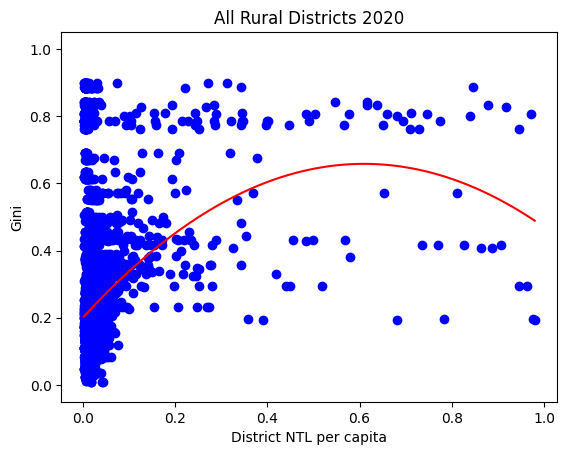

In [344]:
full3 = full3[full3['subdist_ntl_pc'] <= 1]
full3 = full3[full3['alesina'] > 0]

# Create a scatterplot
plt.scatter(full3['subdist_ntl_pc'], full3['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Gini")
plt.title("All Rural Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(full3['subdist_ntl_pc'], full3['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(full3['subdist_ntl_pc']), max(full3['subdist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')
# plt.xlim(0,20)
plt.ylim(-0.05,1.05)

# Add a legend
# plt.legend()
# Display the plot
plt.show()

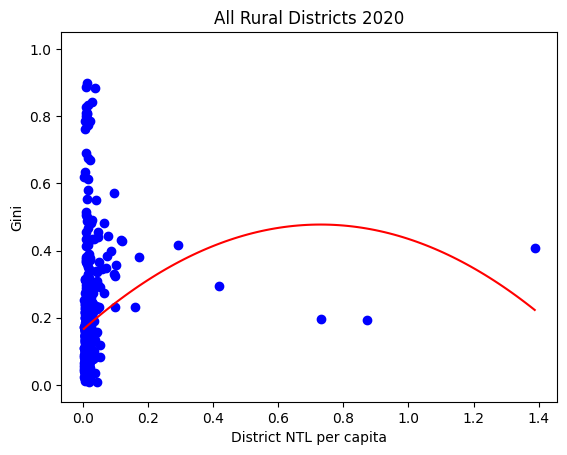

In [332]:
# all = all[all['dist_ntl_pc'] <= 0.1]
all = all[all['alesina'] > 0]

# Create a scatterplot
plt.scatter(all['dist_ntl_pc'], all['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Gini")
plt.title("All Rural Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(all['dist_ntl_pc'], all['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(all['dist_ntl_pc']), max(all['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')
# plt.xlim(0,20)
plt.ylim(-0.05,1.05)

# Add a legend
# plt.legend()
# Display the plot
plt.show()

## Try 2 - avg after sum

In [134]:
t2 = aggregated_df.groupby(['DISTRICT', 'STATE_UT']).sum().reset_index()
t2

/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_15516/3151121.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km
0,Adilabad,Andhra Pradesh,31810.86914,62664.05859,67732.72656,66284.50000,60201.76953,40240.89844,40017.32031,32874.53906,23023.25000,53711.26172,69401.29688,60341.32031,18218.42010
1,Agra,Uttar Pradesh,47299.98047,62756.76953,55485.26953,51821.71875,46731.76172,46252.73047,43017.46094,35705.94141,42417.58984,48900.85938,59048.69141,54363.55078,5134.38087
2,Ahmadabad,Gujarat,105758.25000,115219.50781,107420.10938,104347.93750,100768.60938,93907.14062,88901.73438,63377.77734,77664.08594,95451.35156,104589.94531,99215.89062,9415.66489
3,Ahmadnagar,Maharashtra,78288.53125,109726.23438,106962.92969,114089.54688,106125.36719,68628.63281,68440.61719,67398.39062,32741.69922,68025.08594,113031.22656,107344.46094,19304.50544
4,Aizawl,Mizoram,1994.13989,6453.04980,7102.10010,8858.30078,7213.53955,5988.60010,787.39001,5395.53027,3086.57983,6773.20020,7290.95996,6710.95020,4018.13553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,Yadgir,Karnataka,12078.54883,19821.45898,20658.08984,20812.80859,18116.08008,21674.09961,10413.48047,13795.45020,11798.20996,14305.66016,19774.77930,18788.39062,5704.50647
637,Yamunanagar,Haryana,13059.15918,18295.80859,15520.81055,16510.43945,15550.36914,14243.23047,13706.71973,11743.00977,14805.10938,17220.25000,21273.57031,15612.31934,2300.69356
638,Yanam,Puducherry,510.87000,508.63000,476.04999,452.41000,447.83002,512.73999,438.28000,133.37999,328.85999,371.17999,529.57001,639.45001,17.58468
639,Yavatmal,Maharashtra,32980.91797,62255.59766,55003.66016,57847.62891,52384.26953,15266.96973,41496.87109,35517.30859,27911.28125,42748.58984,60737.53906,54425.71875,15481.37461


In [138]:
selected_columns = t2[['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']]

# Calculating quartiles for each row
quartiles = selected_columns.quantile([0.20, 0.75], axis=1).T
quartiles.columns = ['Q1', 'Q3']  # Rename columns to Q1 and Q3
quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']
quartiles['U_bound'] = quartiles['Q3'] + 1.5*quartiles['IQR']
quartiles['L_bound'] = quartiles['Q1'].clip(lower=0)  # Clip to ensure it's not negative 
# quartiles['L_bound'] = quartiles['L_bound']

# Adding Q1 and Q3 columns to the original DataFrame
t3 = pd.concat([t2, quartiles], axis=1)
# Computing IQR for each row
# iqr = quartiles.loc[0.75] - quartiles.loc[0.25]

# Printing or storing the IQR values
# print(iqr)
t3

,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km,Q1,Q3,IQR,U_bound,L_bound
0,Adilabad,Andhra Pradesh,31810.86914,62664.05859,67732.72656,66284.50000,60201.76953,40240.89844,40017.32031,32874.53906,23023.25000,53711.26172,69401.29688,60341.32031,18218.42010,34303.09531,63569.16895,29266.07363,107468.27939,34303.09531
1,Agra,Uttar Pradesh,47299.98047,62756.76953,55485.26953,51821.71875,46731.76172,46252.73047,43017.46094,35705.94141,42417.58984,48900.85938,59048.69141,54363.55078,5134.38087,43664.51484,54643.98047,10979.46562,71113.17891,43664.51484
2,Ahmadabad,Gujarat,105758.25000,115219.50781,107420.10938,104347.93750,100768.60938,93907.14062,88901.73438,63377.77734,77664.08594,95451.35156,104589.94531,99215.89062,9415.66489,89902.81563,104882.02148,14979.20586,127350.83027,89902.81563
3,Ahmadnagar,Maharashtra,78288.53125,109726.23438,106962.92969,114089.54688,106125.36719,68628.63281,68440.61719,67398.39062,32741.69922,68025.08594,113031.22656,107344.46094,19304.50544,68108.19219,107939.90430,39831.71211,167687.47246,68108.19219
4,Aizawl,Mizoram,1994.13989,6453.04980,7102.10010,8858.30078,7213.53955,5988.60010,787.39001,5395.53027,3086.57983,6773.20020,7290.95996,6710.95020,4018.13553,3548.36992,7129.95996,3581.59004,12502.34502,3548.36992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,Yadgir,Karnataka,12078.54883,19821.45898,20658.08984,20812.80859,18116.08008,21674.09961,10413.48047,13795.45020,11798.20996,14305.66016,19774.77930,18788.39062,5704.50647,12421.92910,20030.61670,7608.68760,31443.64810,12421.92910
637,Yamunanagar,Haryana,13059.15918,18295.80859,15520.81055,16510.43945,15550.36914,14243.23047,13706.71973,11743.00977,14805.10938,17220.25000,21273.57031,15612.31934,2300.69356,13814.02188,16687.89209,2873.87021,20998.69741,13814.02188
638,Yanam,Puducherry,510.87000,508.63000,476.04999,452.41000,447.83002,512.73999,438.28000,133.37999,328.85999,371.17999,529.57001,639.45001,17.58468,384.59999,511.33749,126.73750,701.44374,384.59999
639,Yavatmal,Maharashtra,32980.91797,62255.59766,55003.66016,57847.62891,52384.26953,15266.96973,41496.87109,35517.30859,27911.28125,42748.58984,60737.53906,54425.71875,15481.37461,33488.19609,55714.65234,22226.45625,89054.33672,33488.19609


In [142]:
avg_columns = ['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']
# Create a mask to filter out values below L_Bound
mask = t3[avg_columns].values > t3['L_bound'].values[:, None]

# Replace values below L_Bound with NaN
masked_data = t3[avg_columns].where(mask)

# Calculate row-wise mean
row_means = masked_data.mean(axis=1)

# Add row-wise mean to DataFrame
t3['avg_ntl'] = row_means
t3['dist_ntl_pa']  = t3['avg_ntl']/t3['area_sq_km']

t3 = t3.drop(['202001', '202002', '202003', '202004',
       '202005', '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', 'area_sq_km', 'Q1', 'Q3', 'IQR', 'U_bound', 'L_bound',
       'avg_ntl'], axis=1)
t3



,DISTRICT,STATE_UT,dist_ntl_pa
0,Adilabad,Andhra Pradesh,3.17502
1,Agra,Uttar Pradesh,10.22868
2,Ahmadabad,Gujarat,10.93543
3,Ahmadnagar,Maharashtra,5.02265
4,Aizawl,Mizoram,1.70854
...,...,...,...
636,Yadgir,Karnataka,3.26734
637,Yamunanagar,Haryana,7.19744
638,Yanam,Puducherry,28.53387
639,Yavatmal,Maharashtra,3.31881


In [146]:
t3.to_csv('/Users/sid/Desktop/distsums.csv',index=False)

In [143]:
full3 = pd.merge(full,t3,on=['DISTRICT','STATE_UT'],how='left')


full_sorted3 = full3.sort_values(by=['STATE_UT','DISTRICT', 'subdist_ntl_pa'])
full_sorted3['Index'] = full_sorted3.groupby(['STATE_UT','DISTRICT']).cumcount() + 1
# Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
full_sorted3['Max_Len'] = full_sorted3.groupby(['STATE_UT','DISTRICT'])['Index'].transform('max')
full_sorted3

,NAME,DISTRICT,STATE_UT,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km,Q1,Q3,IQR,U_bound,L_bound,avg_ntl,pop,subdist_ntl_pa,dist_ntl_pa,Index,Max_Len
1908,Great Nicobar,Nicobars,Andaman & Nicobar Islands,239.94998,1200.57007,1817.42993,1866.40002,1331.69995,1371.21997,2146.29980,1348.53003,668.64001,1223.68994,1171.68005,825.26996,1107.59371,894.55198,1482.77246,588.22048,2365.10319,894.55198,1497.50220,7060.90820,1.35203,1.45769,1,3
3814,Nancowry,Nicobars,Andaman & Nicobar Islands,65.30000,538.26996,853.96997,1032.31995,690.53003,643.58997,795.29999,766.52997,249.47000,404.65997,651.79999,430.10001,466.72635,409.74798,773.72247,363.97449,1319.68421,409.74798,711.37885,7917.44189,1.52419,1.45769,2,3
996,Car Nicobar,Nicobars,Andaman & Nicobar Islands,157.96001,277.63998,337.30997,392.67001,257.29001,148.39999,320.82001,290.78998,226.28000,231.91000,270.56000,226.42000,131.71622,226.30800,298.29749,71.98949,406.28172,226.30800,289.48999,14409.14258,2.19783,1.45769,3,3
4693,Rangat,North & Middle Andaman,Andaman & Nicobar Islands,206.89000,1720.89014,2356.46997,2886.10986,2334.14014,2094.84009,781.61993,2163.97998,320.61002,1716.02002,1921.32007,1252.73999,1382.74511,875.84395,2206.52002,1330.67607,4202.53413,875.84395,2049.61230,33214.91797,1.48228,1.48424,1,3
3516,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,113.83000,893.63007,1225.99988,1488.10999,1128.68994,1066.62012,733.29004,1127.55005,23.93000,714.31006,994.87000,663.83997,699.23869,673.93398,1127.83502,453.90104,1808.68658,673.93398,1041.45227,24818.98828,1.48941,1.48424,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Kaliaganj,Uttar Dinajpur,West Bengal,1475.79004,1665.46997,1815.15991,2014.86011,1320.51001,968.15002,135.83000,1170.08008,1185.18994,1455.12988,2262.56982,1575.12000,369.81854,1173.10205,1702.89246,529.79041,2497.57806,1173.10205,1641.08887,239470.01560,4.43755,5.23609,6,10
2575,Karandighi,Uttar Dinajpur,West Bengal,1658.65991,2187.09985,2384.85986,2320.63013,1632.56006,1503.64001,469.04999,1128.40002,1605.92004,1755.25000,3137.14014,2080.50000,467.31884,1524.09602,2220.48242,696.38640,3265.06202,1524.09602,2084.73560,419105.06250,4.46106,5.23609,7,10
1245,Chopra,Uttar Dinajpur,West Bengal,2079.62012,2393.83008,2957.07007,2830.26001,1707.09009,1407.25000,1316.12012,1786.79004,1962.72998,2210.10010,3364.72998,2433.47998,478.63089,1723.03008,2532.67499,809.64491,3747.14235,1723.03008,2446.51245,280278.18750,5.11148,5.23609,8,10
4559,Raiganj,Uttar Dinajpur,West Bengal,3466.98999,4064.46997,4158.94043,4133.62988,3272.47974,1218.13000,613.75000,1803.91016,3034.06982,3520.56006,5281.15039,3566.60010,582.11669,2049.94209,4081.75995,2031.81786,7129.48674,2049.94209,3833.20996,879017.50000,6.58495,5.23609,9,10


In [152]:
def calculate_alesina(group):
    sum_y = group['subdist_ntl_pa'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['subdist_ntl_pa'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

# Calculate WCV for each state using groupby and apply
ale = full_sorted3.groupby([
    'DISTRICT','STATE_UT',
                        #   'dist_ntl','dist_population',
                          'dist_ntl_pa'
                          ]).apply(calculate_alesina).reset_index()

# Reset the index and rename the result column
ale.columns = ['DISTRICT','STATE_UT','dist_ntl_pa',
            #    'dist_population','dist_ntl_pc',
               'sum_y','numerator', 'num','alesina']


ale

,DISTRICT,STATE_UT,dist_ntl_pa,sum_y,numerator,num,alesina
0,Adilabad,Andhra Pradesh,3.17502,182.77526,3722.07719,52.00000,0.23599
1,Agra,Uttar Pradesh,10.22868,71.11443,155.16252,6.00000,0.43938
2,Ahmadabad,Gujarat,10.93543,163.69804,398.52851,11.00000,0.64827
3,Ahmadnagar,Maharashtra,5.02265,74.20239,481.91078,14.00000,0.14364
4,Aizawl,Mizoram,1.70854,9.31973,23.27600,5.00000,0.20100
...,...,...,...,...,...,...,...
636,Yadgir,Karnataka,3.26734,9.84877,19.28190,3.00000,0.02813
637,Yamunanagar,Haryana,7.19744,19.50090,33.49315,3.00000,0.18832
638,Yanam,Puducherry,28.53387,28.53387,28.53387,1.00000,0.00000
639,Yavatmal,Maharashtra,3.31881,52.98365,400.53041,16.00000,0.11756


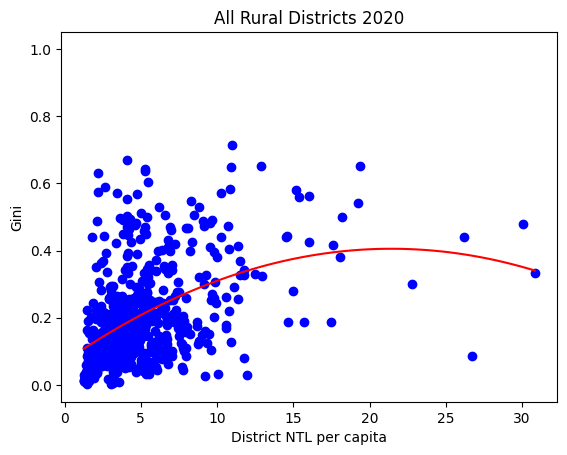

In [155]:
ale = ale[ale['dist_ntl_pa'] <= 35]
ale = ale[ale['alesina'] > 0]

# Create a scatterplot
plt.scatter(ale['dist_ntl_pa'], ale['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Gini")
plt.title("All Rural Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(ale['dist_ntl_pa'], ale['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(ale['dist_ntl_pa']), max(ale['dist_ntl_pa']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')
# plt.xlim(0,20)
plt.ylim(-0.05,1.05)

# Add a legend
# plt.legend()
# Display the plot
plt.show()

## Village Level

In [292]:
# import geopandas as gpd
# import rasterio
# from rasterio.mask import mask
# import numpy as np

vil_gdf = gpd.read_file('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/maps-master/Village/TELANGANA.geojson')
vil_NTL = vil_gdf.copy()

# Loop through each month
# for month in range(1, 13):
# Construct the path to the raster file for the current month
raster_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/GPW/gpw_v4_population_density_rev11_2020_30_sec.tif"

# Open the raster file
with rasterio.open(raster_path) as rasterFile:

    # Define a function to create mask for the current month
    def clean_mask(geom, dataset=rasterFile, mask_kw=None):
        mask_kw = mask_kw or {}
        mask_kw.setdefault("crop", True)
        mask_kw.setdefault("all_touched", True)
        masked, mask_transform = mask(dataset=dataset, shapes=[geom], **mask_kw)
        # print(f"Shape of masked array: {masked.shape}")  # Debugging
        return masked
    
    # Apply mask to each geometry and calculate sum of luminosity for the current month
    statewise_agg_ntl = vil_gdf.geometry.apply(lambda geom: clean_mask(geom, dataset=rasterFile, mask_kw={"crop": True, "all_touched": True})).apply(np.ma.sum)

    print(f"radiance_datacube shape: {statewise_agg_ntl.shape}")  # Debugging
    
    # Add a column to the DataFrame for the current month
    vil_NTL[f"2020"] = statewise_agg_ntl

vil_NTL = vil_NTL.drop('geometry',axis=1)
vil_NTL


radiance_datacube shape: (10105,)


,OBJECTID,VILNAM_SOI,DTNAME.x,STNAME,Shape_Length,Shape_Area,STCODE11,DTCODE11.x,SDTCODE11,VILCODE11,SDTNAME,VILNAME11.x,State code,State Name(In English),State census code,District code,District Name(In English),District Census code,SubDistrict code,Subdistrict Name(In English),Subdistrict census code,Village code,Village Name(In English),Block code,Block Name(In English),2020
0,138061,GIRGAON,ADILABAD,TELANGANA,15047.63162,11637501.71889,36,532,04305,568962,Tamsi,Girgaon,36.00000,TELANGANA,0.00000,501.00000,ADILABAD,532,4305.00000,Tamsi,04305,568962.00000,Girgaon,4679.00000,TAMSI,-inf
1,139060,ANTARGAON,ADILABAD,TELANGANA,11004.40482,6291635.64004,36,532,04305,568948,Tamsi,Antargaon,36.00000,TELANGANA,0.00000,501.00000,ADILABAD,532,6223.00000,BHEEMPUR,00000,568948.00000,Antergaon,4679.00000,TAMSI,-inf
2,139061,GOMUTRI,ADILABAD,TELANGANA,19353.91611,12706805.84943,36,532,04305,568947,Tamsi,Gomutri,36.00000,TELANGANA,0.00000,501.00000,ADILABAD,532,6223.00000,BHEEMPUR,00000,568947.00000,Gomutri,4679.00000,TAMSI,-inf
3,139062,GUBIDI,ADILABAD,TELANGANA,12997.80085,8612544.98844,36,532,04305,568946,Tamsi,Guledi,36.00000,TELANGANA,0.00000,501.00000,ADILABAD,532,4305.00000,Tamsi,04305,568946.00000,Guledi,4679.00000,TAMSI,-inf
4,139063,KARANJI,ADILABAD,TELANGANA,19550.51439,22137541.18823,36,532,04305,568945,Tamsi,Karanji (T),36.00000,TELANGANA,0.00000,501.00000,ADILABAD,532,6223.00000,BHEEMPUR,00000,568945.00000,Karanji (T),4679.00000,TAMSI,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,60623,PALLEVADA,KHAMMAM,TELANGANA,16261.14097,9490082.95889,36,541,04768,579899,Vemsoor,Pallevada,36.00000,TELANGANA,0.00000,509.00000,KHAMMAM,541,4768.00000,Vemsoor,04768,579899.00000,Pallevada,5093.00000,VEMSOOR,-inf
10101,60646,CHAUDAVARAM,KHAMMAM,TELANGANA,15785.84080,14085528.60409,36,541,04768,579898,Vemsoor,Chowdaram,36.00000,TELANGANA,0.00000,509.00000,KHAMMAM,541,4768.00000,Vemsoor,04768,579898.00000,Chowdaram (Ogiralavada),5093.00000,VEMSOOR,-inf
10102,60658,KALLURUGUDEM,KHAMMAM,TELANGANA,19394.52132,14668876.79534,36,541,04768,579902,Vemsoor,Kallurugudem,36.00000,TELANGANA,0.00000,509.00000,KHAMMAM,541,4768.00000,Vemsoor,04768,579902.00000,Kallurugudem,5093.00000,VEMSOOR,-inf
10103,60663,ADASARLAPADU,KHAMMAM,TELANGANA,19912.94254,17649731.70744,36,541,04768,579897,Vemsoor,Adsarlapadu,36.00000,TELANGANA,0.00000,509.00000,KHAMMAM,541,4768.00000,Vemsoor,04768,579897.00000,Adasarlapadu,5093.00000,VEMSOOR,-inf


In [347]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np

# Directory containing the GeoJSON files
geojson_dir = '/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/maps-master/Village/'

# Initialize an empty GeoDataFrame to store the concatenated results
vil_NTL = gpd.GeoDataFrame()

# Loop through each file in the directory
for filename in os.listdir(geojson_dir):
    # Check if the file is a GeoJSON file
    if filename.endswith('.geojson'):
        # Read the GeoJSON file into a GeoDataFrame
        vil_gdf = gpd.read_file(os.path.join(geojson_dir, filename))

        print(f"State: {filename} started")  # Debugging

        # Loop through each month
        for month in range(1, 13):
            # Construct the path to the raster file for the current month
            raster_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/VIIRS_Monthly_Tiled/2020/clean_files/output_raster_2020{month:02d}.tif"
            cf_cvg_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/VIIRS_Monthly_Tiled/cf_cvg/2020_cvg/2020{month:02d}.tif"
            
            # Open the raster file
            with rasterio.open(raster_path) as rasterFile, rasterio.open(cf_cvg_path) as cf_cvg_file:
                # Read the data from cloud-free coverage file
                cf_cvg_data = cf_cvg_file.read(1)

                # Define a function to create mask for the current month
                def clean_mask(geom, dataset=rasterFile, mask_kw=None):
                    mask_kw = mask_kw or {}
                    mask_kw.setdefault("crop", True)
                    mask_kw.setdefault("all_touched", True)
                    masked, mask_transform = mask(dataset=dataset, shapes=[geom], **mask_kw)
                    return masked
                
                # Apply mask to each geometry and calculate sum of luminosity for the current month
                statewise_agg_ntl = vil_gdf.geometry.apply(lambda geom: clean_mask(geom, dataset=rasterFile, mask_kw={"crop": True, "all_touched": True})).apply(np.ma.sum)

                # Add a column to the GeoDataFrame for the current month
                vil_gdf[f"2020{month:02d}"] = statewise_agg_ntl

        # Drop the 'geometry' column and concatenate the GeoDataFrame to vil_NTL
        vil_NTL = pd.concat([vil_NTL, vil_gdf], ignore_index=True)

        print(f"State: {filename} completed")  # Debugging

# Print the concatenated GeoDataFrame
vil_NTL


State: ODISHA.geojson started
State: ODISHA.geojson completed
State: KARNATAKA.geojson started
State: KARNATAKA.geojson completed
State: UTTAR PRADESH.geojson started
State: UTTAR PRADESH.geojson completed
State: DAMAN & DIU.geojson started
State: DAMAN & DIU.geojson completed
State: ANDHRA PRADESH.geojson started
State: ANDHRA PRADESH.geojson completed
State: MAHARASHTRA.geojson started
State: MAHARASHTRA.geojson completed
State: ANDAMAN & NICOBAR.geojson started
State: ANDAMAN & NICOBAR.geojson completed
State: PUNJAB.geojson started
State: PUNJAB.geojson completed
State: TELANGANA.geojson started
State: TELANGANA.geojson completed
State: LAKSHADWEEP.geojson started
State: LAKSHADWEEP.geojson completed
State: JHARKHAND.geojson started
State: JHARKHAND.geojson completed
State: CHANDIGARH.geojson started
State: CHANDIGARH.geojson completed
State: GOA.geojson started
State: GOA.geojson completed
State: GUJARAT.geojson started
State: GUJARAT.geojson completed
State: HARYANA.geojson start

,OBJECTID,VILNAM_SOI,DTNAME.x,STNAME,Shape_Length,Shape_Area,STCODE11,DTCODE11.x,SDTCODE11,VILCODE11,SDTNAME,VILNAME11.x,State code,State Name(In English),State census code,District code,District Name(In English),District Census code,SubDistrict code,Subdistrict Name(In English),Subdistrict census code,Village code,Village Name(In English),Block code,Block Name(In English),geometry,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012
0,350962,MENKAMUNDA,BARGARH,ODISHA,8388.51656,3490441.01418,21,370,02755,379812,Paikamal,Makhanamunda,21.00000,ODISHA,21.00000,347.00000,BARGARH,370,2755.00000,Paikamal,02755,379812.00000,Makhanamunda,3320.00000,PAIKMAL,"MULTIPOLYGON (((82.73533 20.73472, 82.73582 20...",1.23000,9.20000,10.04000,13.28000,11.37000,8.69000,9.34000,0.00000,9.97000,11.49000,14.09000,13.44000
1,351439,TEMRIMAL,BARGARH,ODISHA,12636.72444,7143708.46815,21,370,02755,379818,Paikamal,Temrimal,21.00000,ODISHA,21.00000,347.00000,BARGARH,370,2755.00000,Paikamal,02755,379818.00000,Temrimal,3320.00000,PAIKMAL,"MULTIPOLYGON (((82.71534 20.76881, 82.71724 20...",3.23000,15.97000,16.76000,22.96000,19.19000,13.88000,13.44000,1.84000,18.88000,21.43000,24.62000,19.37000
2,351441,JHARBANDHA,BARGARH,ODISHA,10041.95577,4820085.05740,21,370,02755,379816,Paikamal,Jharbandha,21.00000,ODISHA,21.00000,347.00000,BARGARH,370,2755.00000,Paikamal,02755,379816.00000,Jharbandha,3320.00000,PAIKMAL,"MULTIPOLYGON (((82.70236 20.74693, 82.70360 20...",1.78000,12.31000,13.13000,18.21000,15.67000,10.59000,13.74000,3.39000,14.77000,15.15000,17.34000,14.95000
3,351442,GANJADABAR,BARGARH,ODISHA,7648.13695,3142344.14656,21,370,02755,379814,Paikamal,Ganjadabar,21.00000,ODISHA,21.00000,347.00000,BARGARH,370,2755.00000,Paikamal,02755,379814.00000,Ganjadabar,3320.00000,PAIKMAL,"MULTIPOLYGON (((82.69929 20.75101, 82.70144 20...",2.12000,9.59000,10.58000,14.49000,12.32000,8.44000,3.25000,0.00000,10.61000,12.29000,13.64000,12.24000
4,351443,JALAGARA,BARGARH,ODISHA,6634.92856,2709566.61318,21,370,02755,379815,Paikamal,Jalgarh,21.00000,ODISHA,21.00000,347.00000,BARGARH,370,2755.00000,Paikamal,02755,379815.00000,Jalgarh,3320.00000,PAIKMAL,"MULTIPOLYGON (((82.71261 20.76159, 82.71523 20...",0.76000,7.35000,8.53000,11.66000,10.51000,7.06000,8.16000,0.90000,9.60000,9.70000,11.08000,9.19000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576565,464,VILAPPIL,THIRUVANANTHAPURAM,KERALA,24098.03029,22566441.90660,32,601,05692,628539,Neyyattinkara,Vilappil (CT),32.00000,KERALA,32.00000,565.00000,THIRUVANANTHAPURAM,601,5945.00000,Kattakkada,00000,628539.00000,Vilappil (CT),6074.00000,NEMOM,"MULTIPOLYGON (((77.01523 8.54741, 77.01538 8.5...",327.50000,418.51001,356.21002,360.10999,259.15997,274.97998,242.50002,378.26999,215.59999,308.00000,310.12000,331.21002
576566,465,KALLIKKAD,THIRUVANANTHAPURAM,KERALA,20471.83333,15404115.65774,32,601,05692,628522,Neyyattinkara,Kallikkad,32.00000,KERALA,32.00000,565.00000,THIRUVANANTHAPURAM,601,5945.00000,Kattakkada,00000,628522.00000,Kallikkad,6076.00000,PERUMKADAVILA,"MULTIPOLYGON (((77.13090 8.55455, 77.13200 8.5...",90.47000,130.81000,108.79000,105.49000,83.60001,85.77000,8.74000,130.93001,82.29000,111.50999,112.00000,111.64999
576567,473,VAZHICHAL,THIRUVANANTHAPURAM,KERALA,73964.88430,118869522.64424,32,601,05692,628523,Neyyattinkara,Vazhichal,32.00000,KERALA,32.00000,565.00000,THIRUVANANTHAPURAM,601,5945.00000,Kattakkada,00000,628523.00000,Vazhichal,6076.00000,PERUMKADAVILA,"MULTIPOLYGON (((77.23154 8.61807, 77.23217 8.6...",86.50000,272.44000,282.70001,315.32001,272.86002,247.92999,56.17000,403.88998,207.94000,244.85999,274.78998,220.42001
576568,493,PARASUVAKKAL,THIRUVANANTHAPURAM,KERALA,14169.46057,9741415.36337,32,601,05692,628546,Neyyattinkara,Parasuvaikkal (CT),32.00000,KERALA,32.00000,565.00000,THIRUVANANTHAPURAM,601,5692.00000,Neyyattinkara,05692,628546.00000,Parasuvaikkal (CT),6075.00000,PA

In [348]:
vil_2=vil_NTL.copy()
values_to_drop = ['west pgs', 'New District', 'New Districtffff', 'Sadaruru']
# Dropping rows with specified values in the 'District' column
vil_2 = vil_2[~vil_2['District Name(In English)'].isin(values_to_drop)]
# Reproject to a suitable projected CRS for accurate area calculations
vil_2 = vil_2.to_crs('EPSG:3857')  # Example: Albers Equal Area Conic for India (EPSG:102033)

# Calculate the area in square kilometers
vil_2['area_sq_km'] = vil_2.geometry.area / 1e6


In [349]:
# Replace NaN values in 'State code' with values from 'STCODE11'
vil_2['State code'].fillna(vil_2['STCODE11'], inplace=True)
vil_2['State Name(In English)'].fillna(vil_2['STNAME'], inplace=True)
vil_2['District Name(In English)'].fillna(vil_2['DTNAME.x'], inplace=True)
vil_2['Subdistrict Name(In English)'].fillna(vil_2['SDTNAME'], inplace=True)
vil_2['Village code'].fillna(vil_2['VILCODE11'], inplace=True)
vil_2['Village Name(In English)'].fillna(vil_2['VILNAM_SOI'], inplace=True)


# Group the DataFrame by 'Subdistrict Name(In English)', 'District Name(In English)', and 'State Name(In English)'
grouped = vil_2.groupby(['Subdistrict Name(In English)', 'District Name(In English)', 'State Name(In English)'], group_keys=False)
# Define a function to fill NaN values with the first non-NaN value within each group
def fill_na_with_group_first(group):
    group['District code'].fillna(method='ffill', inplace=True)
    group['SubDistrict code'].fillna(method='ffill', inplace=True)
    return group
# Apply the function to each group and concatenate the results
vil_2 = grouped.apply(fill_na_with_group_first)
# Reset the index
vil_2.reset_index(drop=True, inplace=True)


vil_2 = vil_2.drop(['OBJECTID','VILNAM_SOI','DTNAME.x', 'STNAME', 'Shape_Length',
       'Shape_Area', 'STCODE11', 'DTCODE11.x', 'SDTCODE11', 'VILCODE11',
       'SDTNAME', 'VILNAME11.x', 'State census code','District Census code',
       'Subdistrict census code','geometry'
                  ],axis=1)

vil_2 = vil_2.rename(columns={'State Name(In English)': 'State', 'District Name(In English)': 'District',
                                    'Subdistrict Name(In English)':'Subdistrict',
                                    'Village Name(In English)':'Village','Block Name(In English)':'Block'})

vil_2

,State code,State,District code,District,SubDistrict code,Subdistrict,Village code,Village,Block code,Block,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km
0,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379812.00000,Makhanamunda,3320.00000,PAIKMAL,1.23000,9.20000,10.04000,13.28000,11.37000,8.69000,9.34000,0.00000,9.97000,11.49000,14.09000,13.44000,3.49044
1,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379818.00000,Temrimal,3320.00000,PAIKMAL,3.23000,15.97000,16.76000,22.96000,19.19000,13.88000,13.44000,1.84000,18.88000,21.43000,24.62000,19.37000,7.14371
2,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379816.00000,Jharbandha,3320.00000,PAIKMAL,1.78000,12.31000,13.13000,18.21000,15.67000,10.59000,13.74000,3.39000,14.77000,15.15000,17.34000,14.95000,4.82009
3,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379814.00000,Ganjadabar,3320.00000,PAIKMAL,2.12000,9.59000,10.58000,14.49000,12.32000,8.44000,3.25000,0.00000,10.61000,12.29000,13.64000,12.24000,3.14234
4,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379815.00000,Jalgarh,3320.00000,PAIKMAL,0.76000,7.35000,8.53000,11.66000,10.51000,7.06000,8.16000,0.90000,9.60000,9.70000,11.08000,9.19000,2.70957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576557,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628539.00000,Vilappil (CT),6074.00000,NEMOM,327.50000,418.51001,356.21002,360.10999,259.15997,274.97998,242.50002,378.26999,215.59999,308.00000,310.12000,331.21002,22.56644
576558,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628522.00000,Kallikkad,6076.00000,PERUMKADAVILA,90.47000,130.81000,108.79000,105.49000,83.60001,85.77000,8.74000,130.93001,82.29000,111.50999,112.00000,111.64999,15.40412
576559,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628523.00000,Vazhichal,6076.00000,PERUMKADAVILA,86.50000,272.44000,282.70001,315.32001,272.86002,247.92999,56.17000,403.88998,207.94000,244.85999,274.78998,220.42001,118.86952
576560,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5692.00000,Neyyattinkara,628546.00000,Parasuvaikkal (CT),6075.00000,PARASSALA,91.93000,112.13000,96.56001,90.03000,67.85000,83.75000,2.18000,119.23000,57.17000,95.13000,110.06999,105.81000,9.74142


In [350]:
print(len(vil_2['SubDistrict code'].unique()))

5640


In [351]:
aggregated_df = vil_2.groupby([
                               'Subdistrict', 'SubDistrict code', 
                               'District','District code']).sum().reset_index()
aggregated_df

/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_11957/325605581.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Subdistrict,SubDistrict code,District,District code,Block code,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km
0,A.Konduru,4998.00000,KRISHNA,510.00000,61188.00000,550.54999,876.16003,981.95001,999.58997,905.59998,869.53003,611.82001,213.34999,856.21997,786.69000,857.82001,850.15997,220.11648
1,ADILABAD URBAN,4306.00000,ADILABAD,501.00000,14285.00000,1096.73999,1320.69006,1077.45007,1004.13000,1088.58008,79.50000,889.66010,1300.98010,1016.87006,1030.53003,1402.42993,1406.56995,40.50377
2,AIDILABAD RURAL,6221.00000,ADILABAD,501.00000,204610.00000,922.76996,1607.45007,1580.34998,1704.83997,1464.54004,281.39999,1323.57996,1325.35999,1460.10999,1324.10999,1694.46997,1522.82996,331.20103
3,ANANDPURI,6061.00000,BANSWARA,88.00000,71736.00000,1369.35999,2479.54004,3188.46997,3580.13989,3276.05005,1770.76001,1742.08997,1621.33997,1038.09998,2329.12988,2684.46997,2428.00000,396.12723
4,ANTHERGAON,6214.00000,PEDDAPALLI,682.00000,65533.00000,1198.94006,1473.88000,1490.65002,1531.58997,1384.54004,1199.00000,767.87000,359.72000,1054.56006,1245.80994,1566.27002,1343.34998,133.38265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634,pisimoni,6575.00000,Anirban,732.00000,5817.00000,1368.28015,1322.66003,1295.38000,1110.54004,942.24994,1073.80994,589.25006,654.31995,0.00000,1272.93005,1731.78003,1089.13000,15.02870
5635,singhsingh,6572.00000,viewnew,728.00000,272452.00000,1343.47998,2251.10010,2650.65991,2483.56982,2036.91003,1868.72998,1438.44995,504.14999,2044.63000,1862.76001,2101.60986,2446.35010,527.70668
5636,subdistrict new,6549.00000,ALLAHABAD,120.00000,839.00000,46.00000,66.77000,53.00000,49.99000,45.27000,0.00000,42.50000,34.10000,33.77000,43.53000,69.25001,60.29000,1.60129
5637,veppur,5953.00000,CUDDALORE,570.00000,6127.00000,33.26000,68.03999,71.20000,72.75000,65.56000,86.99001,65.02000,0.00000,58.03000,75.89000,58.95000,52.39000,14.75732


In [352]:
selected_columns = aggregated_df[['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']]

# Calculating quartiles for each row
quartiles = selected_columns.quantile([0.20, 0.75], axis=1).T
quartiles.columns = ['Q1', 'Q3']  # Rename columns to Q1 and Q3
# quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']
# quartiles['U_bound'] = quartiles['Q3'] + 1.5*quartiles['IQR']
quartiles['L_bound'] = quartiles['Q1'].clip(lower=0)  # Clip to ensure it's not negative 

# Adding Q1 and Q3 columns to the original DataFrame
t3 = pd.concat([aggregated_df, quartiles], axis=1)

avg_columns = ['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']
# Create a mask to filter out values below L_Bound
mask = t3[avg_columns].values > t3['L_bound'].values[:, None]

# Replace values below L_Bound with NaN
masked_data = t3[avg_columns].where(mask)

# Calculate row-wise mean
row_means = masked_data.mean(axis=1)

# Add row-wise mean to DataFrame
t3['avg_ntl'] = row_means
t3['subdist_ntl_pa']  = t3['avg_ntl']/t3['area_sq_km']
# t3['subdist_ntl_pc']  = t3['avg_ntl']/t3['total_population']
t3 = t3.rename(columns={'area_sq_km': 'SubDistrict Area'})

t3 = t3.drop(['202001', '202002', '202003', '202004',
       '202005', '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', 'Q1', 'Q3', 'L_bound','Block code',
       # 'SubDistrict code',
       'avg_ntl'], axis=1)
t3

,Subdistrict,SubDistrict code,District,District code,SubDistrict Area,subdist_ntl_pa
0,A.Konduru,4998.00000,KRISHNA,510.00000,220.11648,4.03005
1,ADILABAD URBAN,4306.00000,ADILABAD,501.00000,40.50377,29.46458
2,AIDILABAD RURAL,6221.00000,ADILABAD,501.00000,331.20103,4.59072
3,ANANDPURI,6061.00000,BANSWARA,88.00000,396.12723,6.58561
4,ANTHERGAON,6214.00000,PEDDAPALLI,682.00000,133.38265,10.35786
...,...,...,...,...,...,...
5634,pisimoni,6575.00000,Anirban,732.00000,15.02870,82.85449
5635,singhsingh,6572.00000,viewnew,728.00000,527.70668,4.15768
5636,subdistrict new,6549.00000,ALLAHABAD,120.00000,1.60129,33.07049
5637,veppur,5953.00000,CUDDALORE,570.00000,14.75732,4.68641


In [353]:
vil_3 = pd.merge(vil_2,t3,on=[
    'Subdistrict','SubDistrict code',
    'District','District code'],how='left')

In [354]:
selected_columns = vil_3[['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']]

# Calculating quartiles for each row
quartiles = selected_columns.quantile([0.20, 0.75], axis=1).T
quartiles.columns = ['Q1', 'Q3']  # Rename columns to Q1 and Q3
# quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']
# quartiles['U_bound'] = quartiles['Q3'] + 1.5*quartiles['IQR']
quartiles['L_bound'] = quartiles['Q1'].clip(lower=0)  # Clip to ensure it's not negative 

# Adding Q1 and Q3 columns to the original DataFrame
vil_4 = pd.concat([vil_3, quartiles], axis=1)

avg_columns = ['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']
# Create a mask to filter out values below L_Bound
mask = vil_4[avg_columns].values > vil_4['L_bound'].values[:, None]

# Replace values below L_Bound with NaN
masked_data = vil_4[avg_columns].where(mask)

# Calculate row-wise mean
row_means = masked_data.mean(axis=1)

# Add row-wise mean to DataFrame
vil_4['avg_ntl'] = row_means
vil_4['ntl_pa']  = vil_4['avg_ntl']/vil_4['area_sq_km']
# vil_4 = vil_4.rename(columns={'area_sq_km': 'SubDistrict Area'})

vil_4 = vil_4.drop(['202001', '202002', '202003', '202004',
       '202005', '202006', '202007', '202008', '202009', '202010', '202011',
       '202012', 'Q1', 'Q3', 'L_bound'], axis=1)

vil_4 = vil_4[vil_4['area_sq_km']>1]

vil_4 = vil_4.sort_values(by=['State','District', 
                              'Subdistrict',
                              'ntl_pa'])
vil_4['Index'] = vil_4.groupby(['State','District',
                                'Subdistrict'
                                ]).cumcount() + 1
# # Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
vil_4['Max_Len'] = vil_4.groupby(['State','District',
                                  'Subdistrict'
                                  ])['Index'].transform('max')

vil_4

,State code,State,District code,District,SubDistrict code,Subdistrict,Village code,Village,Block code,Block,area_sq_km,SubDistrict Area,subdist_ntl_pa,avg_ntl,ntl_pa,Index,Max_Len
237731,35,ANDAMAN & NICOBAR,NaN,NICOBARS,NaN,Great Nicobar,645163,KONDUL,NaN,NaN,1.64049,NaN,NaN,4.04667,2.46675,1,1
237697,35,ANDAMAN & NICOBAR,NaN,NICOBARS,NaN,Nancowry,,MEROE,NaN,NaN,1.45023,NaN,NaN,2.99444,2.06480,1,1
237839,35,ANDAMAN & NICOBAR,NaN,NORTH & MIDDLE ANDAMAN,NaN,Diglipur,,NORTH & MIDDLE ANDAMAN PROTECT,NaN,NaN,328.40391,NaN,NaN,467.36893,1.42315,1,15
237780,35,ANDAMAN & NICOBAR,NaN,NORTH & MIDDLE ANDAMAN,NaN,Diglipur,,NORTH REEF ISLAND,NaN,NaN,3.65491,NaN,NaN,6.66778,1.82433,2,15
237814,35,ANDAMAN & NICOBAR,NaN,NORTH & MIDDLE ANDAMAN,NaN,Diglipur,,PAGET ISLAND (UTTAR TIKRI),NaN,NaN,4.61334,NaN,NaN,8.85778,1.92003,3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345815,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330486.00000,Shunuri,3063.00000,SANTURI,6.08302,212.31490,8.11621,89.51334,14.71528,74,78
345798,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330493.00000,Beljhupa,3063.00000,SANTURI,1.35389,212.31490,8.11621,21.19444,15.65449,75,78
345779,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330522.00000,Dhuluri,3063.00000,SANTURI,1.21851,212.31490,8.11621,23.72666,19.47192,76,78
345818,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330487.00000,Deuli,3063.00000,SANTURI,2.71736,212.31490,8.11621,67.84444,24.96707,77,78


In [355]:
def calculate_alesina(group):
    sum_y = group['ntl_pa'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pa'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

# Calculate WCV for each state using groupby and apply
ale = vil_4.groupby(['State','District',
                     'Subdistrict','SubDistrict code',
                          'subdist_ntl_pa'
                          ]).apply(calculate_alesina).reset_index()

# Reset the index and rename the result column
ale.columns = ['State','District',
               'Subdistrict','SubDistrict code',
               'subdist_ntl_pa',
               'sum_y','numerator', 'num','alesina']

ale

,State,District,Subdistrict,SubDistrict code,subdist_ntl_pa,sum_y,numerator,num,alesina
0,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,Car Nicobar,5916.00000,2.15094,2.15094,2.15094,1.00000,0.00000
1,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,Great Nicobar,5918.00000,1.37716,30.54440,115.19297,10.00000,0.34573
2,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,Nancowry,5917.00000,1.44244,12.97944,54.91814,8.00000,0.06721
3,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Diglipur,5919.00000,1.89344,149.08961,1583.63109,34.00000,0.40459
4,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Mayabunder,5920.00000,2.53485,104.77404,996.59021,24.00000,0.24902
...,...,...,...,...,...,...,...,...,...
5632,WESTBENGAL,PURULIA,Purulia - I,2387.00000,5.59263,615.80051,23891.03634,101.00000,0.24165
5633,WESTBENGAL,PURULIA,Purulia - II,2379.00000,9.67282,885.09703,26120.09137,93.00000,0.37611
5634,WESTBENGAL,PURULIA,Raghunathpur - I,2382.00000,8.06275,550.94110,14167.58137,66.00000,0.23590
5635,WESTBENGAL,PURULIA,Raghunathpur - II,2381.00000,17.12818,1553.64065,25846.30113,74.00000,0.56389


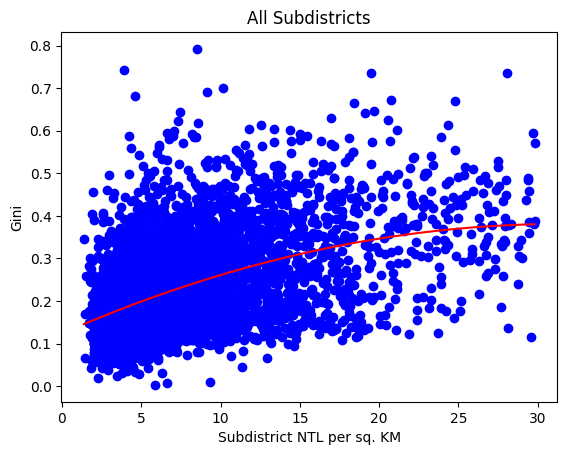

In [364]:
# ale['alesina'] = ale['alesina'].abs()
ale = ale[ale['subdist_ntl_pa'] <= 30]
ale = ale[ale['alesina'] > 0]
# ale = ale[ale['num']>10]
# ale = ale[ale['alesina'] < 1]


# Create a scatterplot
plt.scatter(ale['subdist_ntl_pa'], ale['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("Subdistrict NTL per sq. KM")
plt.ylabel("Gini")
plt.title("All Subdistricts")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(ale['subdist_ntl_pa'], ale['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(ale['subdist_ntl_pa']), max(ale['subdist_ntl_pa']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')
# plt.xlim(0,20)
# plt.ylim(-0.05,1.05)

# Add a legend
# plt.legend()
# Display the plot
plt.show()

In [226]:
ale

,State,District,Subdistrict,SubDistrict code,subdist_ntl_pa,sum_y,numerator,num,alesina
1,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,Great Nicobar,5918.00000,1.37716,30.54440,115.19297,10.00000,0.34573
2,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,Nancowry,5917.00000,1.44244,12.97944,54.91814,8.00000,0.06721
3,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Diglipur,5919.00000,1.89344,149.08961,1583.63109,34.00000,0.40459
4,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Mayabunder,5920.00000,2.53485,104.77404,996.59021,24.00000,0.24902
5,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Rangat,5921.00000,1.67679,165.63298,2642.40967,43.00000,0.28124
...,...,...,...,...,...,...,...,...,...
5634,WESTBENGAL,PURULIA,Purulia - I,2387.00000,5.59263,615.80051,23891.03634,101.00000,0.24165
5635,WESTBENGAL,PURULIA,Purulia - II,2379.00000,9.67282,885.09703,26120.09137,93.00000,0.37611
5636,WESTBENGAL,PURULIA,Raghunathpur - I,2382.00000,8.06275,550.94110,14167.58137,66.00000,0.23590
5637,WESTBENGAL,PURULIA,Raghunathpur - II,2381.00000,17.12818,1553.64065,25846.30113,74.00000,0.56389


## Test with GPW

In [295]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np

# Directory containing the GeoJSON files
gdf = gpd.read_file('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/maps-master/geojson/sub_dist.geojson')

# Now you can work with the GeoDataFrame (gdf) containing the shapefile data
vil_gpw = gdf.copy()

raster_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/GPW/gpw_v4_population_density_rev11_2020_30_sec.tif"

# Open the raster file
with rasterio.open(raster_path) as rasterFile:

    # Define a function to create mask for the current month
    def clean_mask(geom, dataset=rasterFile, mask_kw=None):
        mask_kw = mask_kw or {}
        mask_kw.setdefault("crop", True)
        mask_kw.setdefault("all_touched", True)
        masked, mask_transform = mask(dataset=dataset, shapes=[geom], **mask_kw)
        return masked
    
    # Apply mask to each geometry and calculate sum of luminosity for the current month
    statewise_agg_ntl = vil_gdf.geometry.apply(lambda geom: clean_mask(geom, dataset=rasterFile, mask_kw={"crop": True, "all_touched": True})).apply(np.ma.sum)

    # Add a column to the GeoDataFrame for the current month
    vil_gpw[f"Population"] = statewise_agg_ntl

# Drop the 'geometry' column and concatenate the GeoDataFrame to vil_NTL
# vil_gpw = pd.concat([vil_gdf, vil_gdf], ignore_index=True)

# Print the concatenated GeoDataFrame
vil_gpw


,NAME,DISTRICT,STATE_UT,geometry,Population
0,DATA NOT AVAILABLE,DATA NOT AVAILABLE,Jammu & Kashmir,"MULTIPOLYGON (((74.77117 37.01042, 74.77968 36...",-inf
1,NaN,Kachchh,Gujarat,"MULTIPOLYGON (((70.12473 22.97347, 70.12521 22...",-inf
2,KACHCHH (PART),Kachchh,Gujarat,"MULTIPOLYGON (((71.30731 24.56554, 71.30731 24...",-inf
3,Kupwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((74.57425 34.59931, 74.56734 34...",-inf
4,Handwara,Kupwara,Jammu & Kashmir,"MULTIPOLYGON (((74.13457 34.44413, 74.13615 34...",-inf
...,...,...,...,...,...
6070,Mayabunder,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.72334 12.73736, 92.72345 12...",-inf
6071,Rangat,North & Middle Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.75932 12.16706, 92.75909 12...",-inf
6072,Ferrargunj,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.60467 11.53490, 92.60471 11...",-340282306073709652508363335590014353408.00000
6073,Port Blair,South Andaman,Andaman & Nicobar Islands,"MULTIPOLYGON (((92.61728 10.92835, 92.61446 10...",-inf


In [ ]:

vil_gdf = gpd.read_file('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/maps-master/geojson/sub_dist.geojson')
vil_NTL = vil_gdf.copy()

# Loop through each month
raster_path = f"/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/GPW/gpw_v4_population_density_rev11_2020_30_sec.tif"

# Open the raster file
with rasterio.open(raster_path) as rasterFile:

    # Define a function to create mask for the current month
    def clean_mask(geom, dataset=rasterFile, mask_kw=None):
        mask_kw = mask_kw or {}
        mask_kw.setdefault("crop", True)
        mask_kw.setdefault("all_touched", True)
        masked, mask_transform = mask(dataset=dataset, shapes=[geom], **mask_kw)
        # print(f"Shape of masked array: {masked.shape}")  # Debugging
        return masked
    
    # Apply mask to each geometry and calculate sum of luminosity for the current month
    statewise_agg_ntl = vil_gdf.geometry.apply(lambda geom: clean_mask(geom, dataset=rasterFile, mask_kw={"crop": True, "all_touched": True})).apply(np.ma.sum)

    print(f"radiance_datacube shape: {statewise_agg_ntl.shape}")  # Debugging
    
    # Add a column to the DataFrame for the current month
    vil_NTL[f"2020"] = statewise_agg_ntl

In [282]:
vil_g = vil_g.drop(['OBJECTID','VILNAM_SOI','DTNAME.x', 'STNAME', 'Shape_Length',
       'Shape_Area', 'STCODE11', 'DTCODE11.x', 'SDTCODE11', 'VILCODE11',
       'SDTNAME', 'VILNAME11.x', 'State census code','District Census code',
       'Subdistrict census code','geometry'
                  ],axis=1)

# vil_g = vil_g.rename(columns={'State Name(In English)': 'State', 'District Name(In English)': 'District',
#                                     'Subdistrict Name(In English)':'Subdistrict',
#                                     'Village Name(In English)':'Village','Block Name(In English)':'Block'})

vil_g

,State code,State Name(In English),District code,District Name(In English),SubDistrict code,Subdistrict Name(In English),Village code,Village Name(In English),Block code,Block Name(In English),Population
0,32.00000,KERALA,558.00000,KASARAGOD,5630.00000,Kasaragod,627113.00000,Kolathur,6697.00000,KARADKA,-inf
1,32.00000,KERALA,558.00000,KASARAGOD,5630.00000,Kasaragod,627118.00000,Bandadka,6697.00000,KARADKA,-inf
2,32.00000,KERALA,558.00000,KASARAGOD,5630.00000,Kasaragod,627112.00000,Muliyar,6697.00000,KARADKA,-inf
3,32.00000,KERALA,558.00000,KASARAGOD,5630.00000,Kasaragod,627114.00000,Bedadka,6697.00000,KARADKA,-inf
4,32.00000,KERALA,558.00000,KASARAGOD,5630.00000,Kasaragod,627115.00000,Munnad,6697.00000,KARADKA,-inf
...,...,...,...,...,...,...,...,...,...,...,...
3183,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628539.00000,Vilappil (CT),6074.00000,NEMOM,-inf
3184,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628522.00000,Kallikkad,6076.00000,PERUMKADAVILA,-inf
3185,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628523.00000,Vazhichal,6076.00000,PERUMKADAVILA,-inf
3186,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5692.00000,Neyyattinkara,628546.00000,Parasuvaikkal (CT),6075.00000,PARASSALA,-inf


In [283]:
vil_g.to_csv('/Users/sid/Desktop/testty.csv',index=False)

In [275]:
vil_2

,State code,State,District code,District,SubDistrict code,Subdistrict,Village code,Village,Block code,Block,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,area_sq_km
0,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379812.00000,Makhanamunda,3320.00000,PAIKMAL,1.23000,9.20000,10.04000,13.28000,11.37000,8.69000,9.34000,0.00000,9.97000,11.49000,14.09000,13.44000,3.49044
1,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379818.00000,Temrimal,3320.00000,PAIKMAL,3.23000,15.97000,16.76000,22.96000,19.19000,13.88000,13.44000,1.84000,18.88000,21.43000,24.62000,19.37000,7.14371
2,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379816.00000,Jharbandha,3320.00000,PAIKMAL,1.78000,12.31000,13.13000,18.21000,15.67000,10.59000,13.74000,3.39000,14.77000,15.15000,17.34000,14.95000,4.82009
3,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379814.00000,Ganjadabar,3320.00000,PAIKMAL,2.12000,9.59000,10.58000,14.49000,12.32000,8.44000,3.25000,0.00000,10.61000,12.29000,13.64000,12.24000,3.14234
4,21.00000,ODISHA,347.00000,BARGARH,2755.00000,Paikamal,379815.00000,Jalgarh,3320.00000,PAIKMAL,0.76000,7.35000,8.53000,11.66000,10.51000,7.06000,8.16000,0.90000,9.60000,9.70000,11.08000,9.19000,2.70957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576557,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628539.00000,Vilappil (CT),6074.00000,NEMOM,327.50000,418.51001,356.21002,360.10999,259.15997,274.97998,242.50002,378.26999,215.59999,308.00000,310.12000,331.21002,22.56644
576558,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628522.00000,Kallikkad,6076.00000,PERUMKADAVILA,90.47000,130.81000,108.79000,105.49000,83.60001,85.77000,8.74000,130.93001,82.29000,111.50999,112.00000,111.64999,15.40412
576559,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5945.00000,Kattakkada,628523.00000,Vazhichal,6076.00000,PERUMKADAVILA,86.50000,272.44000,282.70001,315.32001,272.86002,247.92999,56.17000,403.88998,207.94000,244.85999,274.78998,220.42001,118.86952
576560,32.00000,KERALA,565.00000,THIRUVANANTHAPURAM,5692.00000,Neyyattinkara,628546.00000,Parasuvaikkal (CT),6075.00000,PARASSALA,91.93000,112.13000,96.56001,90.03000,67.85000,83.75000,2.18000,119.23000,57.17000,95.13000,110.06999,105.81000,9.74142


## Test with pop from ma

In [179]:
subset_df = pd.read_csv('/Users/sid/Desktop/vilpop.csv')
subset_df

,Village_code,total_population
0,269885,3575.00000
1,269886,3027.00000
2,913569,4989.00000
3,913570,4085.00000
4,913571,2024.00000
...,...,...
647989,437524,1136.00000
647990,437584,2893.00000
647991,449336,300.00000
647992,433505,297.00000


In [187]:
vil_5 = vil_4.dropna(subset=['Village code'])
vil_5 = vil_5[vil_5['Village code'] != ' ']
vil_5['Village code'] = vil_5['Village code'].astype(float)
vil_5 = vil_5.drop(['Index', 'Max_Len'], axis=1)
vil_5

,State code,State,District code,District,SubDistrict code,Subdistrict,Village code,Village,Block code,Block,area_sq_km,SubDistrict Area,subdist_ntl_pa,avg_ntl,ntl_pa
237738,35,ANDAMAN & NICOBAR,NaN,NICOBARS,NaN,Great Nicobar,645163.00000,KONDUL,NaN,NaN,1.64049,NaN,NaN,4.04667,2.46675
238109,35,ANDAMAN & NICOBAR,NaN,SOUTH ANDAMAN,NaN,Port Blair,804041.00000,PORT BLAIR,NaN,NaN,20.51807,NaN,NaN,1482.29993,72.24363
237698,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5916.00000,Car Nicobar,645017.00000,Kakana,6500.00000,NANCOWRIE,129.54828,129.54828,2.15094,278.65112,2.15094
237742,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645187.00000,Pulobaha,6498.00000,CAMPBELL BAY,926.03554,1117.28747,1.37716,1164.78210,1.25782
237748,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645149.00000,Kiyang,6498.00000,CAMPBELL BAY,146.04015,1117.28747,1.37716,199.31889,1.36482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345789,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330520.00000,Krishtapur,3063.00000,SANTURI,0.41017,212.31490,8.11621,11.48778,28.00767
345820,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330496.00000,Sashpur,3063.00000,SANTURI,0.48237,212.31490,8.11621,18.31333,37.96512
345818,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330491.00000,Chandurdi,3063.00000,SANTURI,0.99772,212.31490,8.11621,43.50555,43.60501
345825,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330488.00000,Bakuliashota,3063.00000,SANTURI,2.36038,212.31490,8.11621,109.37778,46.33897


In [234]:
popn = pd.merge(vil_5, subset_df, left_on='Village code',
               right_on='Village_code'
                            , how='left')

subdist_ntl_pc = popn.groupby(['SubDistrict code'
                       ]).agg({'total_population': 'sum','avg_ntl':'sum'}).reset_index()
subdist_ntl_pc['subdist_ntl_pc']=subdist_ntl_pc['avg_ntl']/subdist_ntl_pc['total_population']
subdist_ntl_pc = subdist_ntl_pc.drop(['total_population', 'avg_ntl'], axis=1)

pop = pd.merge(popn,subdist_ntl_pc, on='SubDistrict code',how='left')

pop = pop.dropna(subset=['total_population'])
pop = pop[pop['total_population']>10]

pop['ntl_pc']  = pop['avg_ntl']/pop['total_population']

pop = pop.sort_values(by=['State','District', 
                              'Subdistrict',
                              'ntl_pc'])
pop['Index'] = pop.groupby(['State','District',
                                'Subdistrict'
                                ]).cumcount() + 1
# # Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
pop['Max_Len'] = pop.groupby(['State','District',
                                  'Subdistrict'
                                  ])['Index'].transform('max')

pop

,State code,State,District code,District,SubDistrict code,Subdistrict,Village code,Village,Block code,Block,area_sq_km,SubDistrict Area,subdist_ntl_pa,avg_ntl,ntl_pa,Village_code,total_population,subdist_ntl_pc,ntl_pc,Index,Max_Len
11,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645192.00000,Gandhi Nagar,6498.00000,CAMPBELL BAY,5.11255,1117.28747,1.37716,14.55889,2.84768,645192.00000,1020.00000,0.28425,0.01427,1,7
9,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645199.00000,Govinda Nagar,6498.00000,CAMPBELL BAY,7.48149,1117.28747,1.37716,19.04556,2.54569,645199.00000,1062.00000,0.28425,0.01793,2,7
7,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645191.00000,Sastri Nagar,6498.00000,CAMPBELL BAY,4.25078,1117.28747,1.37716,9.91333,2.33212,645191.00000,493.00000,0.28425,0.02011,3,7
8,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645195.00000,Joginder Nagar,6498.00000,CAMPBELL BAY,7.79823,1117.28747,1.37716,19.31778,2.47720,645195.00000,885.00000,0.28425,0.02183,4,7
6,35.00000,ANDAMAN AND NICOBAR ISLANDS,603.00000,NICOBARS,5918.00000,Great Nicobar,645194.00000,Vijoy Nagar,6498.00000,CAMPBELL BAY,7.33305,1117.28747,1.37716,14.39778,1.96341,645194.00000,494.00000,0.28425,0.02915,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532517,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330486.00000,Shunuri,3063.00000,SANTURI,6.08302,212.31490,8.11621,89.51334,14.71528,330486.00000,700.00000,0.00862,0.12788,86,90
532510,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330589.00000,Murulia (CT),3063.00000,SANTURI,4.28451,212.31490,8.11621,52.60112,12.27704,330589.00000,331.00000,0.00862,0.15892,87,90
532512,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330531.00000,Ramchandrapur,3063.00000,SANTURI,1.61474,212.31490,8.11621,20.53333,12.71622,330531.00000,112.00000,0.00862,0.18333,88,90
532514,19.00000,WESTBENGAL,321.00000,PURULIA,2384.00000,Santuri,330494.00000,Madhukunda Alias Mokura,3063.00000,SANTURI,3.49377,212.31490,8.11621,49.14556,14.06663,330494.00000,230.00000,0.00862,0.21368,89,90


In [241]:
def calculate_alesina(group):
    sum_y = group['ntl_pc'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

# Calculate WCV for each state using groupby and apply
als = pop.groupby(['State','District',
                     'Subdistrict','SubDistrict code',
                          'subdist_ntl_pc'
                          ]).apply(calculate_alesina).reset_index()

# Reset the index and rename the result column
als.columns = ['State','District',
               'Subdistrict','SubDistrict code',
               'subdist_ntl_pc',
               'sum_y','numerator', 'num','alesina']

als

,State,District,Subdistrict,SubDistrict code,subdist_ntl_pc,sum_y,numerator,num,alesina
0,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,Great Nicobar,5918.00000,0.28425,0.21489,0.62369,7.00000,0.31359
1,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Diglipur,5919.00000,0.05376,2.55249,13.56384,32.00000,0.69913
2,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Mayabunder,5920.00000,0.02038,0.81193,5.89380,27.00000,0.49933
3,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,Rangat,5921.00000,0.05135,1.60002,13.13910,44.00000,0.64946
4,ANDAMAN AND NICOBAR ISLANDS,SOUTH ANDAMANS,Ferrargunj,5922.00000,0.04614,5.77861,22.48935,46.00000,0.85253
...,...,...,...,...,...,...,...,...,...
5596,WESTBENGAL,PURULIA,Purulia - I,2387.00000,0.00753,2.86159,48.48805,107.00000,0.69263
5597,WESTBENGAL,PURULIA,Purulia - II,2379.00000,0.01623,4.60381,72.73321,102.00000,0.70003
5598,WESTBENGAL,PURULIA,Raghunathpur - I,2382.00000,0.01340,2.32518,37.29125,76.00000,0.59111
5599,WESTBENGAL,PURULIA,Raghunathpur - II,2381.00000,0.01300,6.65939,73.48102,85.00000,0.75214


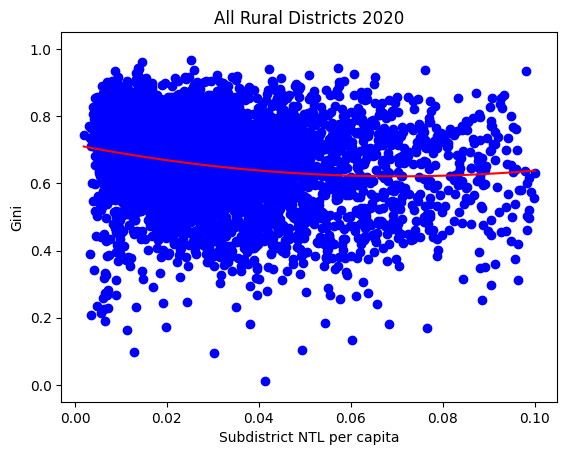

In [243]:
als = als[als['subdist_ntl_pc'] <= 0.1]
als = als[als['alesina'] > 0]

# Create a scatterplot
plt.scatter(als['subdist_ntl_pc'], als['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("Subdistrict NTL per capita")
plt.ylabel("Gini")
plt.title("All Rural Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(als['subdist_ntl_pc'], als['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(als['subdist_ntl_pc']), max(als['subdist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')
# plt.xlim(0,20)
plt.ylim(-0.05,1.05)

# Add a legend
# plt.legend()
# Display the plot
plt.show()

## Export

In [227]:
ale.to_csv('/Users/sid/Desktop/ntlpa.csv',index=False)
als.to_csv('/Users/sid/Desktop/ntlpc.csv',index=False)